# Grand Final
## Phishing Detection

As each coin has two sides, so does technology. On one hand, with the advancement in technology the lives are getting better, on the other hand, the ill use of technology is also increasing. The suspicious activities are increasing ranging from dos attacks, phishing, hacking etc. In this hackathon, we are concerned with the increasing phishing attacks.


Typically, Phishing is a type of social engineering where an attacker sends a fraudulent (e.g., spoofed, fake, or otherwise deceptive) message designed to trick a person into revealing sensitive information to the attacker or to deploy malicious software on the victim's infrastructure like ransomware.


**Task-1:**

The finale is an extension to the problem statement solved in the semi-final. The following tasks needs to be done for the finale:
- Find and list the dominant variables
- Eliminate the Top 2 dominant variables and design a new ML model.
- Provide your analysis on changes seen and how it impacts prediction.
- Provide information on the algorithms selected,metrics selected, hyperparameters and overall results.




**Judging Criteria:**

- Completeness
- Correctness & Performance
- Tasks Completion
- Presentation and Report


**Deliverables:**
- Output file generated by the model.
- Source Code file or .ipynb file or Report
- Report or Presentation with model explanation and changes observed
- Demonstration Video (If Possible)

In [1]:
!wget https://static.techgig.com/files/contest_upload_files/Phising_Training_Dataset.zip
!wget https://static.techgig.com/files/contest_upload_files/Phising_Testing_Dataset.zip
!wget https://static.techgig.com/files/contest_upload_files/Phising_Sample_Submisson.zip

--2022-07-23 14:30:39--  https://static.techgig.com/files/contest_upload_files/Phising_Training_Dataset.zip
Resolving static.techgig.com (static.techgig.com)... 203.77.191.14
Connecting to static.techgig.com (static.techgig.com)|203.77.191.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91206 (89K) [application/zip]
Saving to: ‘Phising_Training_Dataset.zip’

Phising_Training_Da 100%[===================>]  89.07K   491KB/s    in 0.2s    

2022-07-23 14:30:39 (491 KB/s) - ‘Phising_Training_Dataset.zip’ saved [91206/91206]

--2022-07-23 14:30:39--  https://static.techgig.com/files/contest_upload_files/Phising_Testing_Dataset.zip
Resolving static.techgig.com (static.techgig.com)... 203.77.191.14
Connecting to static.techgig.com (static.techgig.com)|203.77.191.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21126 (21K) [application/zip]
Saving to: ‘Phising_Testing_Dataset.zip’

Phising_Testing_Dat 100%[===================>]  20.63K  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install sweetviz
import sweetviz as eda
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.1 MB 3.8 MB/s 


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# set pandas options
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

# /content/drive/MyDrive/TechGig_HPE_ML_2022
root = "/content/drive/MyDrive/TechGig_HPE_ML_2022/HPE_Machine_Learning_Hackathon_CG_2022/Final/%s"

from joblib import dump, load
fontdict = dict(color="green", fontsize=17, fontweight="bold")

In [4]:
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML

# Defining Custom functions


In [5]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

# model building helpers
def performance(logreg, X_train, X_test, y_train, y_test, render=False):
    y_pred_train = logreg.predict(X_train)
    y_pred_test = logreg.predict(X_test)

    metric = dict()
    # plain model score
    metric["Classification report"] = dict(
        train=classification_report(y_train, y_pred_train, output_dict=True),
        test=classification_report(y_test, y_pred_test, output_dict=True)
    )
    if render:
        print("Training: ")
        display(pd.DataFrame(metric["Classification report"]["train"]))
        print("Testing: ")
        display(pd.DataFrame(metric["Classification report"]["test"]))
    return metric

def draw_roc(model, x, y):
    actual, probs = y, model.predict_proba(x)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.4f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None


# Quantile based flooring and capping
def outlier_capping(series, low=0.05, high=0.95):
    # Computing 10th, 90th percentiles and replacing the outliers
    low_percentile = np.percentile(series.values, low*100)
    high_percentile = np.percentile(series.values, high*100)
    # print(col, low_percentile, high_percentile)
    arr = series.values
    arr = np.where(arr < low_percentile, low_percentile, arr)
    arr = np.where(arr > high_percentile, high_percentile, arr)
    return arr


def tuning_performance(model_cv, param, metrics, title):
    cv_df = pd.DataFrame(model_cv.cv_results_)
    ax = cv_df.groupby(f'param_{param}')[metrics].mean().plot(figsize=[8,5])
    ax.set_title(title, fontdict=fontdict)
    plt.show()

In [6]:
# Some function for faster feature searching
import statsmodels.api as sm
from   statsmodels.stats.outliers_influence import variance_inflation_factor
from   sklearn.metrics import r2_score

def vif_p_value_analysis(X, model, key_p_val='P>|z|'):
    """
        Analyse VIF(multicollenirity) and p-value(significance)

        Args:
          X: The dataframe used to train
          model: A statsmodel instance that are trained with X
          key_p_val: For GML() this value is `'P>|z|'`. Specify diffenent value for other models.
        
        Returns:
            DataFrame - Contains VIF(multicollenirity) and p-value(significance) values
                for each predictors.
    """
    # generate VIF for all the features
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False, ignore_index=True)
    
    # Convert the model summary to a dataframe
    results_as_html = model.summary().tables[1].as_html()
    model_summary_df = pd.read_html(results_as_html, header=0)[0]

    # capture the features and the p-values(significances)
    p_values = model_summary_df[['Unnamed: 0', key_p_val, 'coef']]
    p_values['Features'] = p_values['Unnamed: 0']
    p_values.drop(columns='Unnamed: 0', inplace=True)

    # Join the dataframes
    vif_p_value = pd.merge(vif, p_values, on="Features")
    return vif_p_value

def feature_eleminiation_suggestion(vif_p, p_val_cutoff=0.05, vif_cutoff=5, key_p_val='P>|z|', echo=True):
    """
    This function automatically analysis p-value and VIF and provide dropping suggestion.
    with reason.

    Args:
      vif_p: A dataframe returnd by vif_p_value_analysis() function
      p_val_cutoff: The cutoff value for `variable significance`. Default is 5%.
      vif_cutoff: The cutoff value for feature `multi-collinearity`. Default is 5.
      key_p_val: For GLM() this value is `'P>|z|'`. Specify diffenent value for other models.

    Returns:
      tuple: (feature_name, value, flag)
              feature_name: The name of the feature
              value: The read value
              flag: p_value or VIF
  """
    def print_(*args):
      if echo:
        print(*args)

    high_p = vif_p[(vif_p[key_p_val] >= p_val_cutoff) & (vif_p['Features'] != 'const')].sort_values(by=key_p_val, ascending=False, ignore_index=True)
    high_vif = vif_p[(vif_p['VIF'] >= vif_cutoff) & (vif_p['Features'] != 'const')].sort_values(by='VIF', ascending=False, ignore_index=True)

    if high_p.shape[0]:
      print_(f"D R O P     S U G G E S T I O N\n")
      top = high_p.loc[0, ['Features', key_p_val]]
      features = top['Features']
      p_value  = top[key_p_val]
      print_(f"High p-value for '{features}'={p_value}. Drop Insignificant Variable-'{features}'.")
      return features, p_value, "p_value"
    elif high_vif.shape[0]:
      print_(f"D R O P     S U G G E S T I O N\n")
      top = high_vif.loc[0, ['Features', 'VIF']]
      features = top['Features']
      vif  = top['VIF']
      print_(f"High VIF for '{features}'={vif}. Drop multicollineared Variable-'{features}'.")
      return features, vif, "vif"

In [7]:
# Manual feature elemination
import time
import datetime

def manual_feature_elemination(x, y, model_no, p_value_cutoff, vif_cutoff, feature_count=[], key_p_val='P>|z|', save_models=False):
    model = None
    multi_models = []
    train_cols = x.columns
    start_time = time.time()
    print("Started: ", datetime.datetime.now())
    while model is None:
      st = time.time()
      print("\n\n==========================================")
      print("Started: ", datetime.datetime.now())
      print(f"Model:{model_no}\nFeatures({len(train_cols)}):")
      # print features
      #display(train_cols)
      # prepare and train model with the given features
      X_train_sm = sm.add_constant(x[train_cols])
      algo = sm.GLM(y, X_train_sm, family = sm.families.Binomial())
      logm2 = algo.fit()
      # calculate auc score
      reg = LogisticRegression(random_state=42)
      reg.fit(x[train_cols], y)
      probs = reg.predict_proba(x[train_cols])[:, 1]
      auc_score = metrics.roc_auc_score(y, probs )
      # gather VIF and p-values for the fetures
      vif_p_df = vif_p_value_analysis(X_train_sm, logm2, key_p_val=key_p_val)
      print("AUC: ", round(auc_score, 4))
      #display(logm2.summary())
      display(vif_p_df)
      # Analyse if we can drop any features or not for improvement
      status = feature_eleminiation_suggestion(vif_p_df, p_val_cutoff=p_value_cutoff, vif_cutoff=vif_cutoff, key_p_val=key_p_val)
      if len(train_cols) in feature_count or save_models:
        multi_models.append((logm2, train_cols, model_no, status, auc_score, reg))
        print(f"Checkpoint -- Model No:{model_no}, Feature count:{len(train_cols)}")
      if status is None:
        model = logm2
        multi_models.append((logm2, train_cols, model_no, status, auc_score, reg))
        print("No more improvements. Stopping here.")
      else:
        # removing the bad feature
        train_cols = [col for col in train_cols if status[0] != col]
      print(f"Model:{model_no} took {time.time() - st} sec")
      print("Ended: ", datetime.datetime.now())
      model_no += 1
    print(f"Process took {time.time() - start_time} sec")
    print("Ended: ", datetime.datetime.now())
    return multi_models

# Data understanding

In [8]:
# read the data
train = pd.read_csv("./Phising_Training_Dataset.zip")
test = pd.read_csv("./Phising_Testing_Dataset.zip")

In [9]:
# shape
train.shape, test.shape

((8955, 32), (2100, 31))

## Look for datatype and null values

In [10]:
# info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8955 entries, 0 to 8954
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   key                          8955 non-null   int64
 1   having_IP                    8955 non-null   int64
 2   URL_Length                   8955 non-null   int64
 3   Shortining_Service           8955 non-null   int64
 4   having_At_Symbol             8955 non-null   int64
 5   double_slash_redirecting     8955 non-null   int64
 6   Prefix_Suffix                8955 non-null   int64
 7   having_Sub_Domain            8955 non-null   int64
 8   SSLfinal_State               8955 non-null   int64
 9   Domain_registeration_length  8955 non-null   int64
 10  Favicon                      8955 non-null   int64
 11  port                         8955 non-null   int64
 12  HTTPS_token                  8955 non-null   int64
 13  Request_URL                  8955 non-null   int

* The dataset is clean

In [11]:
# train dataset9
train.head()

key  having_IP  URL_Length  Shortining_Service  having_At_Symbol  \
0  12344         -1           1                   1                 1   
1  12345          1           1                   1                 1   
2  12346          1           0                   1                 1   
3  12347          1           0                   1                 1   
4  12348          1           0                  -1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   Domain_registeration_length  Favicon  port  HTTPS_token  Request_URL  \
0                           -1        1     1           -1            1   
1                           -1        1     1           -1            1   
2                           -1        1     1           -1            1   
3                            1        1     1           -1           -1   
4                           -1        1     1            1            1   

   URL_of_Anchor  Links_in_tags  SFH  Submitting_to_email  Abnormal_URL  \
0             -1              1   -1                   -1            -1   
1              0             -1   -1                    1             1   
2              0             -1   -1                   -1            -1   
3              0              0   -1                    1             1   
4              0              0   -1                    1             1   

   Redirect  on_mouseover  RightClick  popUpWidnow  Iframe  age_of_domain  \
0         0             1           1            1       1             -1   
1         0             1           1            1       1             -1   
2         0             1           1            1       1              1   
3         0             1           1            1       1             -1   
4         0            -1           1           -1       1             -1   

   DNSRecord  web_traffic  Page_Rank  Google_Index  Links_pointing_to_page  \
0         -1           -1         -1             1                       1   
1         -1            0         -1             1                       1   
2         -1            1         -1             1                       0   
3         -1            1         -1             1                      -1   
4         -1            0         -1             1                       1   

   Statistical_report  Result  
0                  -1      -1  
1                   1      -1  
2                  -1      -1  
3                   1      -1  
4                   1       1

In [12]:
# test dataset
test.head()

key  having_IP  URL_Length  Shortining_Service  having_At_Symbol  \
0  21338          1           1                   1                 1   
1  21339          1          -1                   1                 1   
2  21340          1          -1                   1                 1   
3  21341         -1          -1                  -1                 1   
4  21342          1          -1                   1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                         1              1                 -1               1   
1                         1             -1                  0              -1   
2                         1             -1                  0               0   
3                        -1             -1                 -1              -1   
4                         1             -1                  1               1   

   Domain_registeration_length  Favicon  port  HTTPS_token  Request_URL  \
0                           -1        1     1            1            1   
1                            1        1     1            1            1   
2                           -1       -1    -1            1           -1   
3                            1       -1    -1           -1           -1   
4                           -1        1     1            1            1   

   URL_of_Anchor  Links_in_tags  SFH  Submitting_to_email  Abnormal_URL  \
0              0              0    1                    1             1   
1             -1             -1   -1                    1             1   
2             -1             -1   -1                   -1             1   
3             -1              1   -1                   -1            -1   
4              0              1   -1                    1             1   

   Redirect  on_mouseover  RightClick  popUpWidnow  Iframe  age_of_domain  \
0         0             1           1            1       1              1   
1         0             1           1            1       1             -1   
2         0            -1          -1           -1      -1              1   
3         1            -1           1           -1      -1              1   
4         0             1           1            1       1              1   

   DNSRecord  web_traffic  Page_Rank  Google_Index  Links_pointing_to_page  \
0          1            1          1            -1                       0   
1         -1            0         -1            -1                       0   
2         -1            1         -1             1                       1   
3         -1            1         -1             1                       1   
4          1            1         -1             1                       0   

   Statistical_report  
0                   1  
1                   1  
2                  -1  
3                  -1  
4                   1

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   key                          2100 non-null   int64
 1   having_IP                    2100 non-null   int64
 2   URL_Length                   2100 non-null   int64
 3   Shortining_Service           2100 non-null   int64
 4   having_At_Symbol             2100 non-null   int64
 5   double_slash_redirecting     2100 non-null   int64
 6   Prefix_Suffix                2100 non-null   int64
 7   having_Sub_Domain            2100 non-null   int64
 8   SSLfinal_State               2100 non-null   int64
 9   Domain_registeration_length  2100 non-null   int64
 10  Favicon                      2100 non-null   int64
 11  port                         2100 non-null   int64
 12  HTTPS_token                  2100 non-null   int64
 13  Request_URL                  2100 non-null   int

## Data Anatomy

- 30 Features
- `key` un-usable variable
- `Result` the target variable

In [14]:
# drop key column
train_key = train['key']
train.drop(columns=['key'], inplace=True)
train.head()

having_IP  URL_Length  Shortining_Service  having_At_Symbol  \
0         -1           1                   1                 1   
1          1           1                   1                 1   
2          1           0                   1                 1   
3          1           0                   1                 1   
4          1           0                  -1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   Domain_registeration_length  Favicon  port  HTTPS_token  Request_URL  \
0                           -1        1     1           -1            1   
1                           -1        1     1           -1            1   
2                           -1        1     1           -1            1   
3                            1        1     1           -1           -1   
4                           -1        1     1            1            1   

   URL_of_Anchor  Links_in_tags  SFH  Submitting_to_email  Abnormal_URL  \
0             -1              1   -1                   -1            -1   
1              0             -1   -1                    1             1   
2              0             -1   -1                   -1            -1   
3              0              0   -1                    1             1   
4              0              0   -1                    1             1   

   Redirect  on_mouseover  RightClick  popUpWidnow  Iframe  age_of_domain  \
0         0             1           1            1       1             -1   
1         0             1           1            1       1             -1   
2         0             1           1            1       1              1   
3         0             1           1            1       1             -1   
4         0            -1           1           -1       1             -1   

   DNSRecord  web_traffic  Page_Rank  Google_Index  Links_pointing_to_page  \
0         -1           -1         -1             1                       1   
1         -1            0         -1             1                       1   
2         -1            1         -1             1                       0   
3         -1            1         -1             1                      -1   
4         -1            0         -1             1                       1   

   Statistical_report  Result  
0                  -1      -1  
1                   1      -1  
2                  -1      -1  
3                   1      -1  
4                   1       1

# Drop Duplicate Entries

In [15]:
# drop duplicate entries
train_unik = train.drop_duplicates()
train_unik.shape, train.shape

((5214, 31), (8955, 31))

In [16]:
# class value counts
train_unik.Result.value_counts()

-1    2639
 1    2575
Name: Result, dtype: int64

# Exploratery Data Analysis

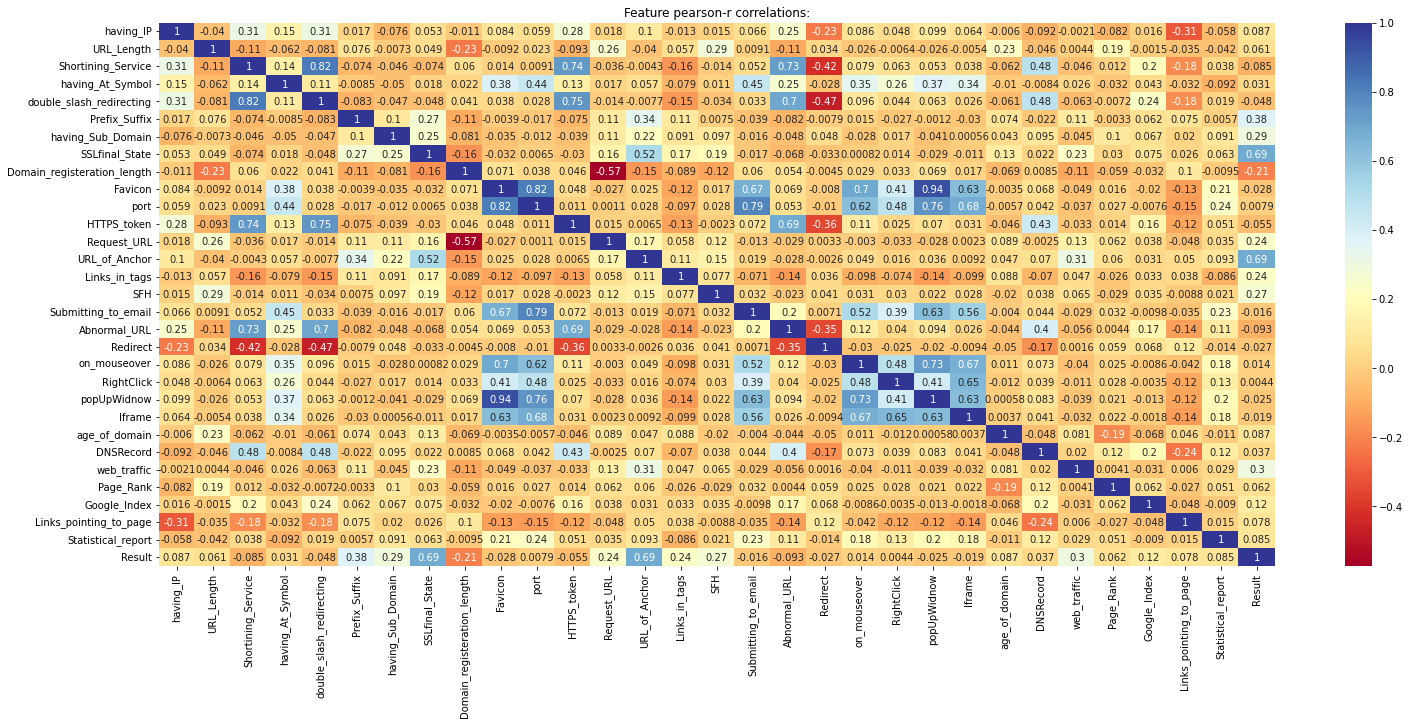

In [17]:
# correlation headmap
corr = train_unik.corr()
plt.figure(figsize=[25, 10])
sns.heatmap(corr, annot=True, cmap="RdYlBu")
plt.title("Feature pearson-r correlations:")
plt.show()

- There are **9 features** is highly correlated with `Result`, target variable, feature
    1. `Prefix_Suffix`
    1. `having_Sub_Domain`
    1. `SSLfinal_State`
    1. `Domain_registeration_length`
    1. `Request_URL`
    1. `URL_of_Anchor`
    1. `Links_in_tags`
    1. `SFH`
    1. `web_traffic`
- Above features has higher potential to identify the `Result` variable accuratly.

                                             |          | [  0%]   00:00 -> (? left)


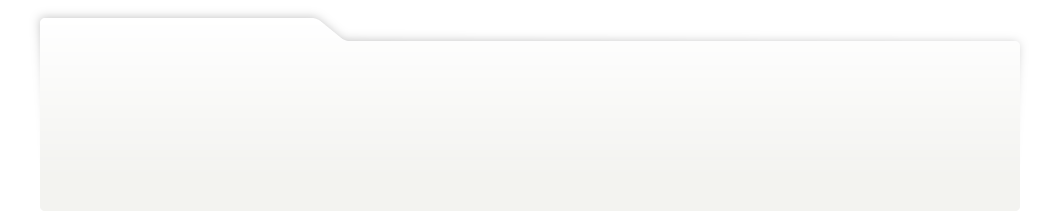
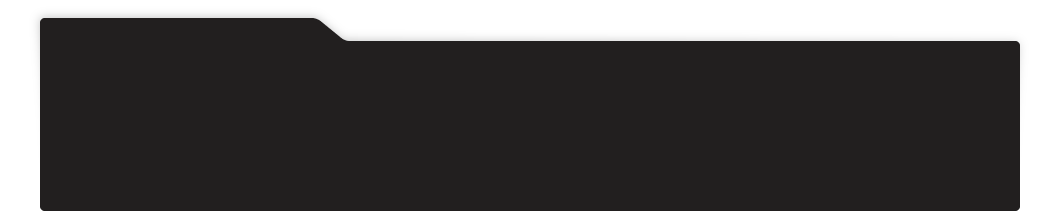
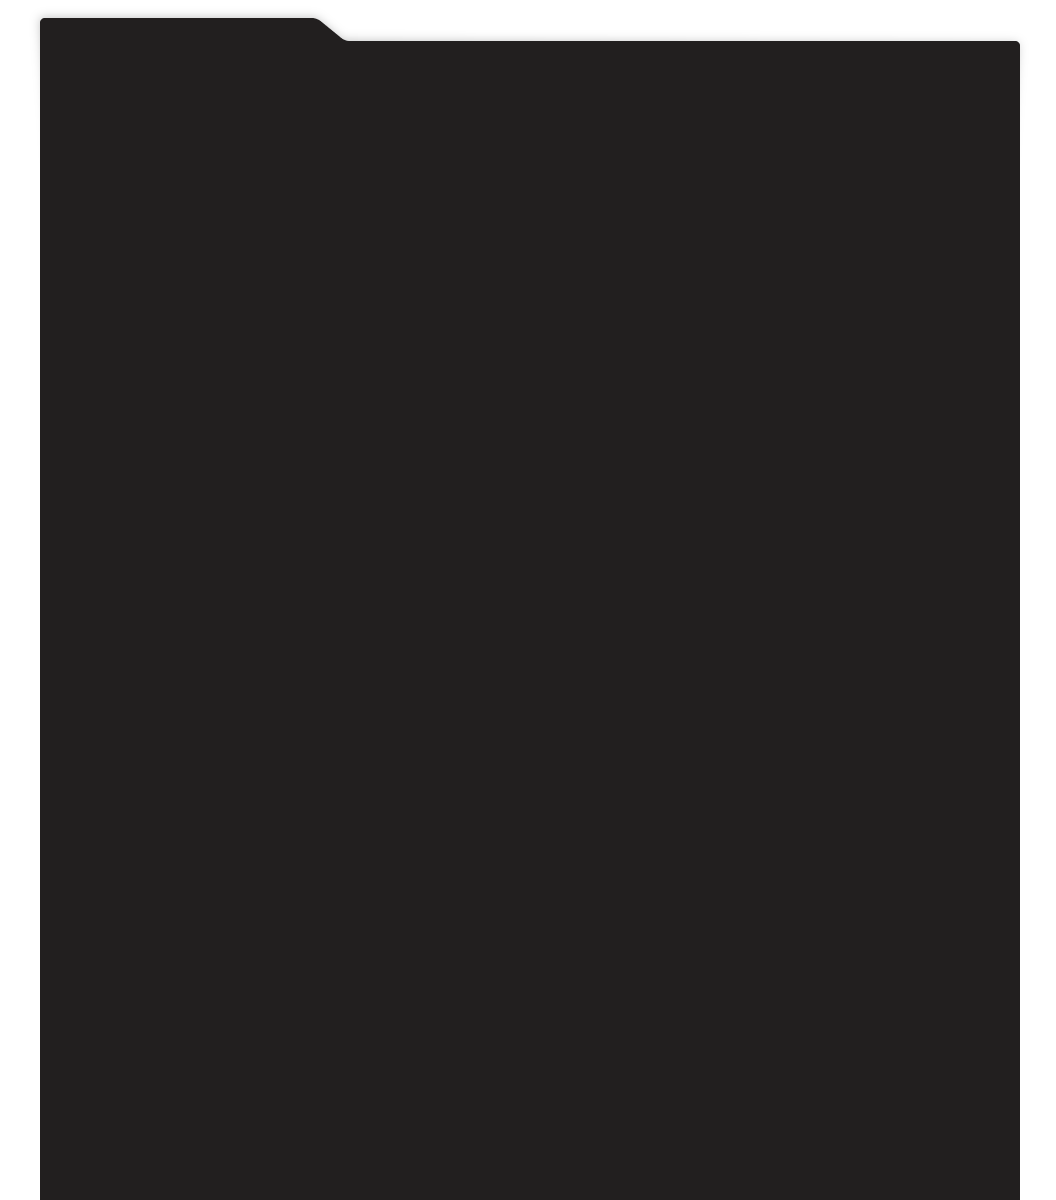
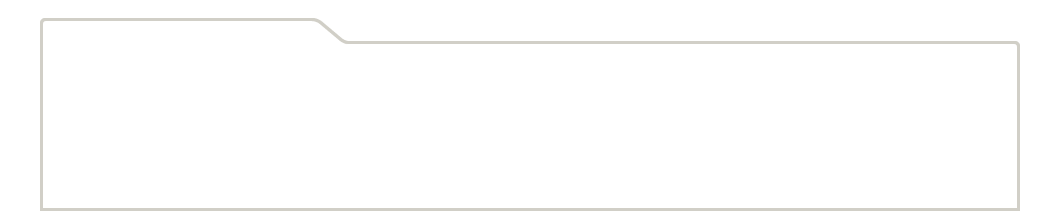
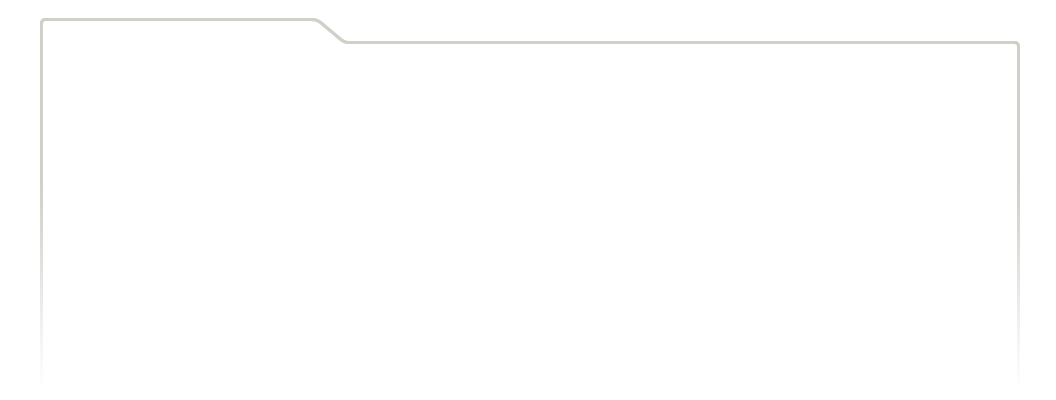
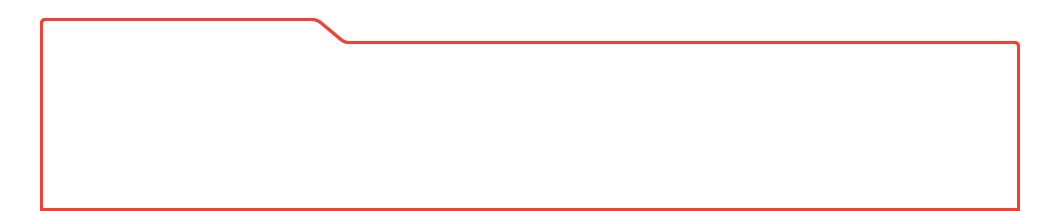
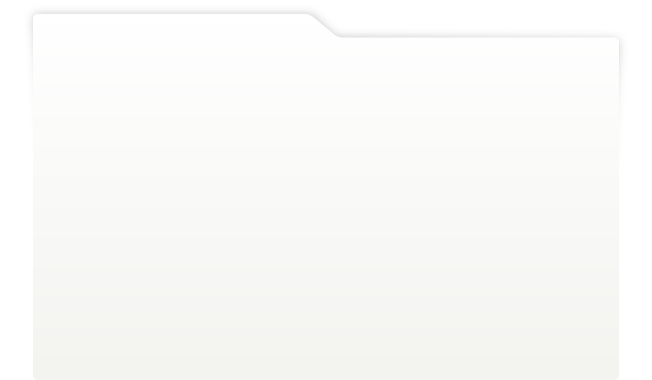
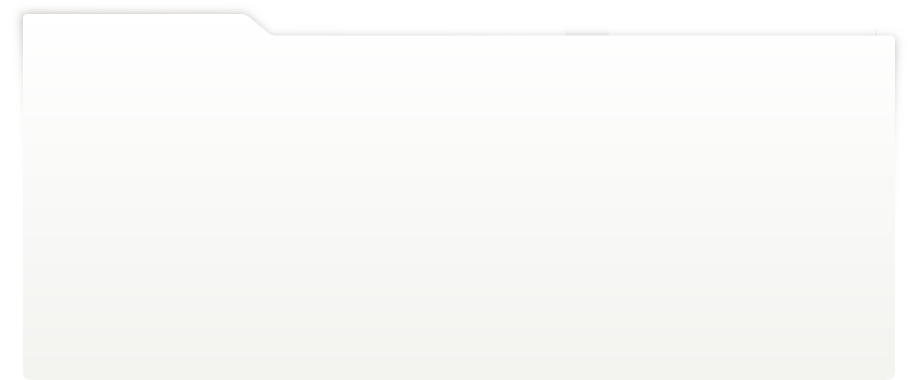
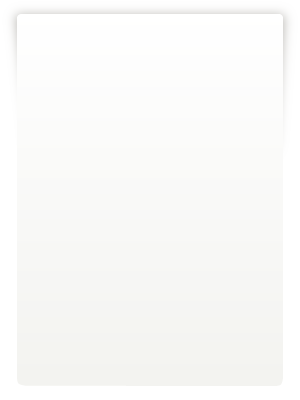
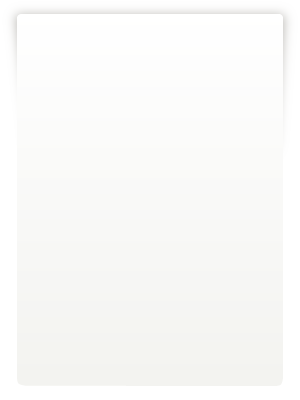
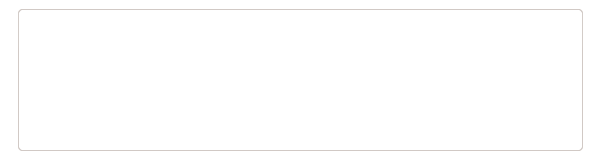
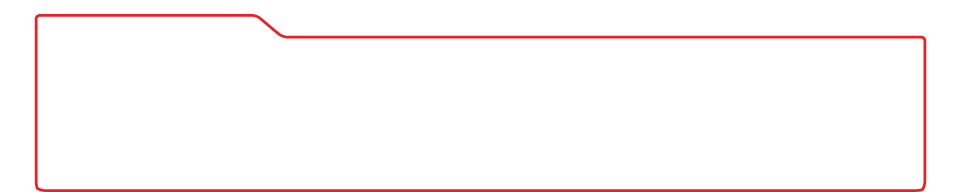
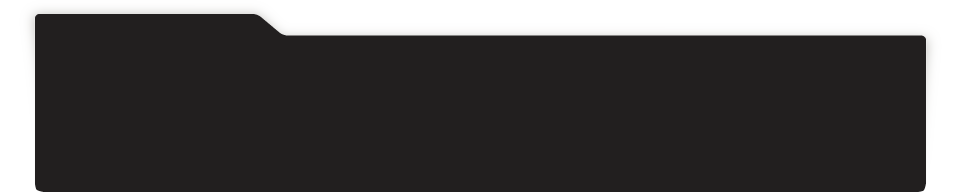
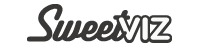
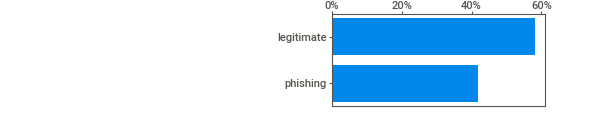
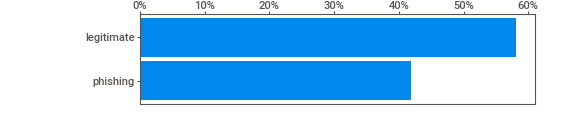
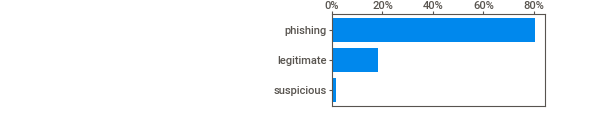
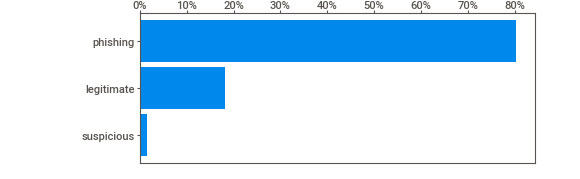
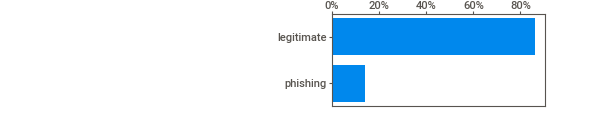
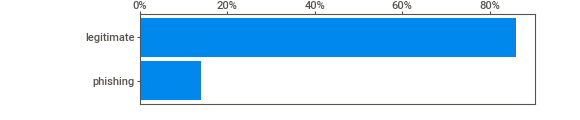
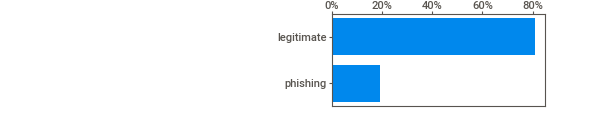
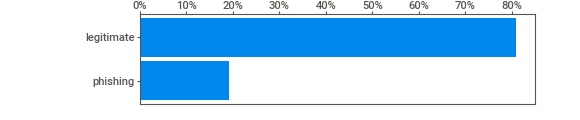
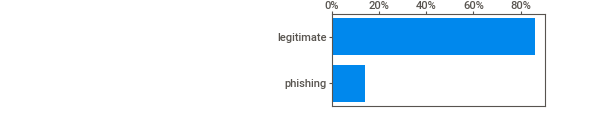
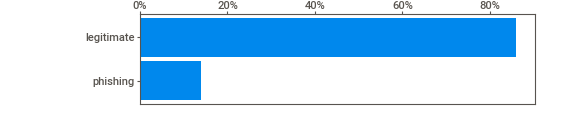
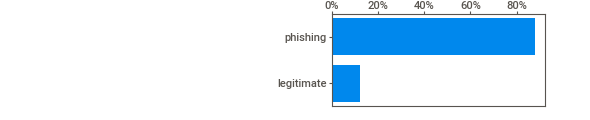
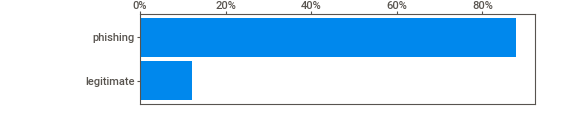
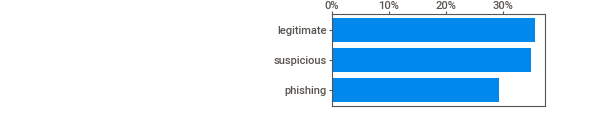
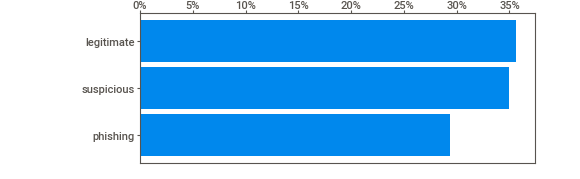
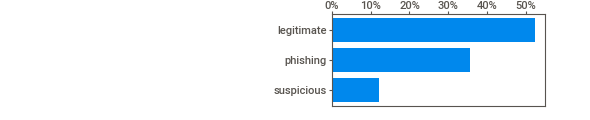
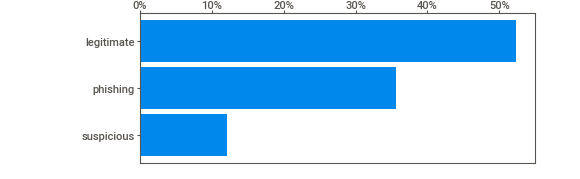
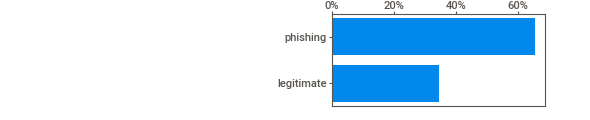
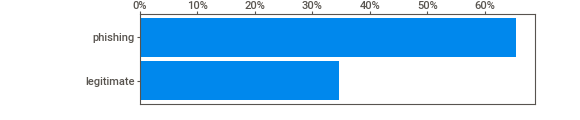
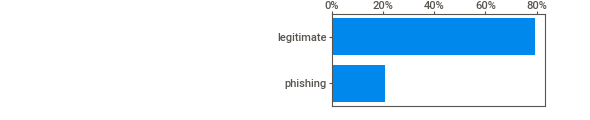
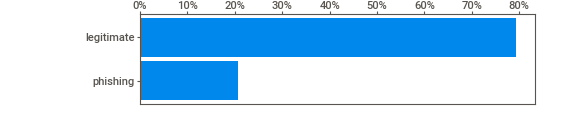
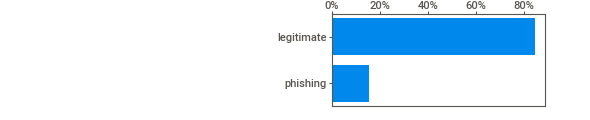
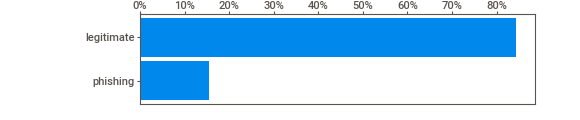
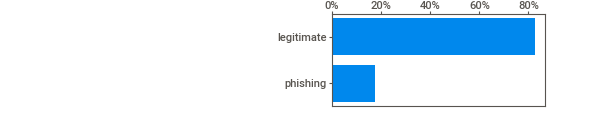
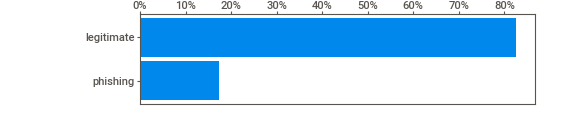
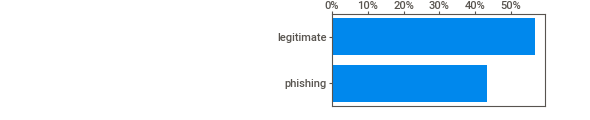
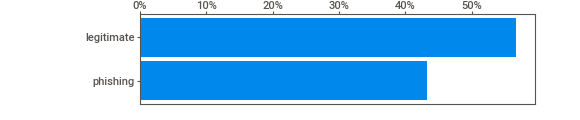
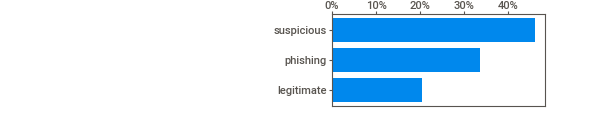
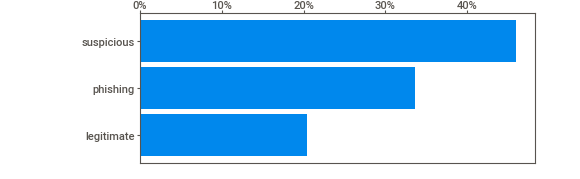
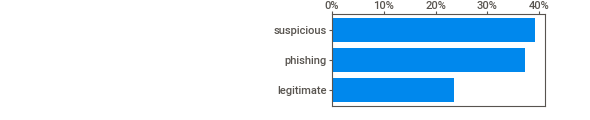
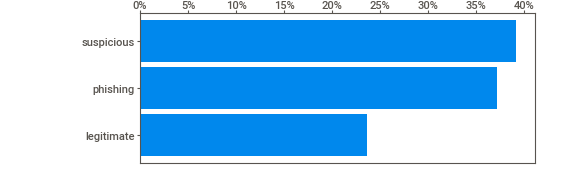
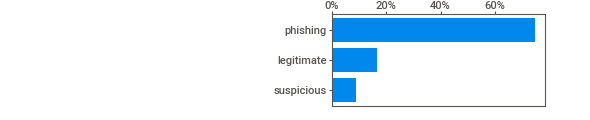
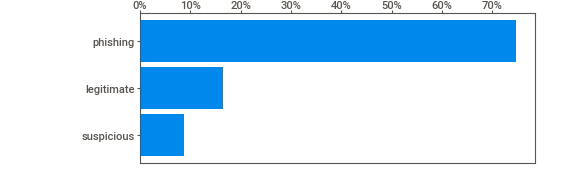
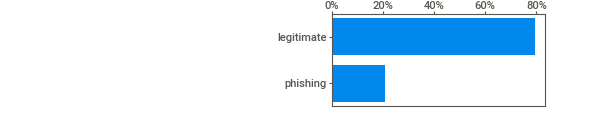
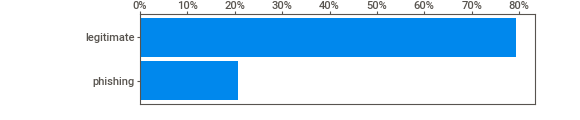
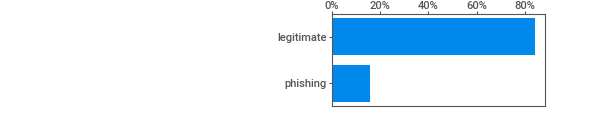
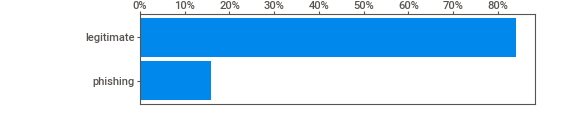
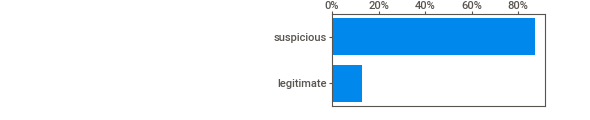
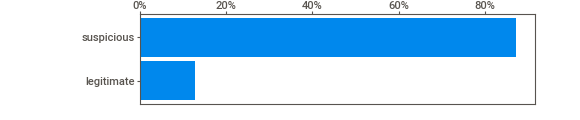
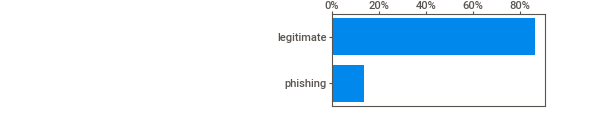
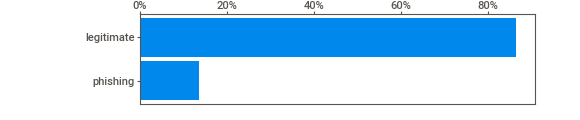
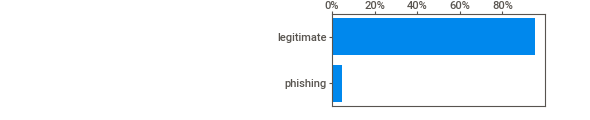
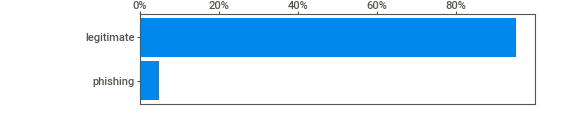
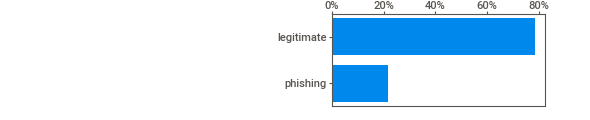
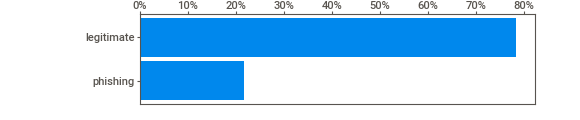
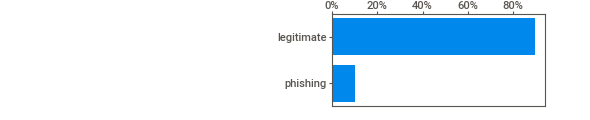
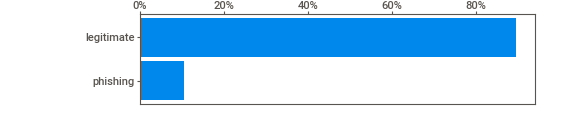
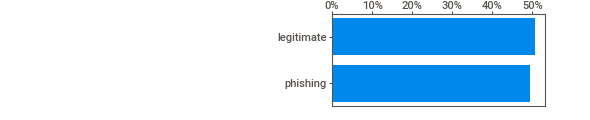
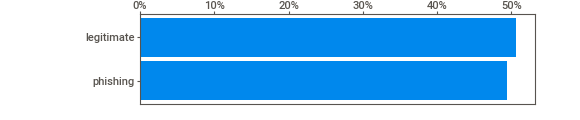
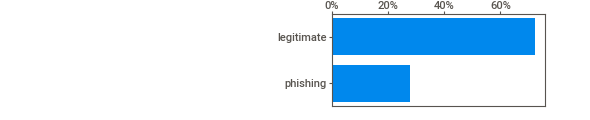
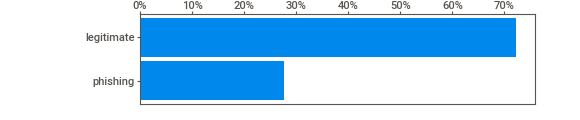
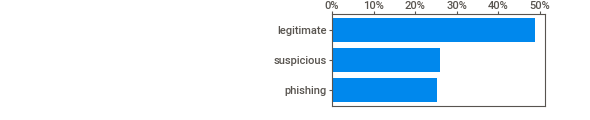
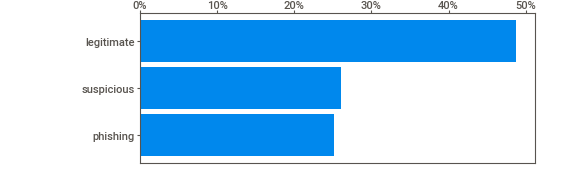
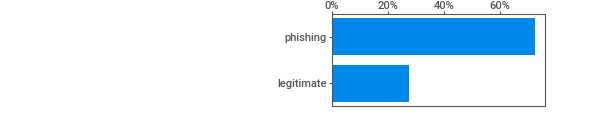
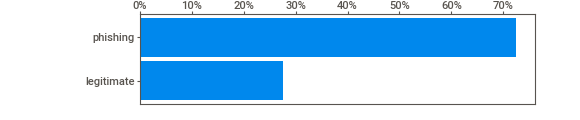
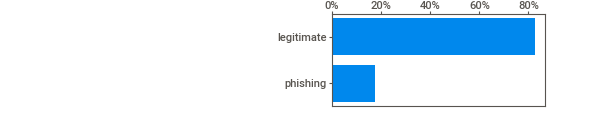
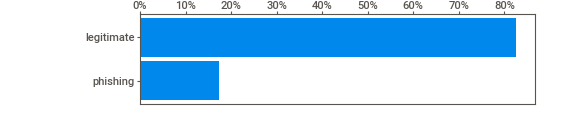
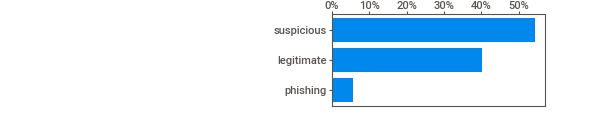
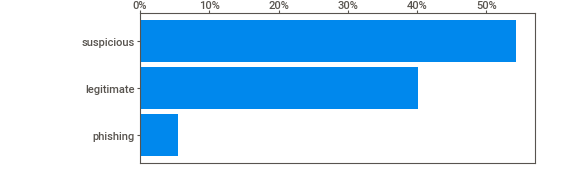
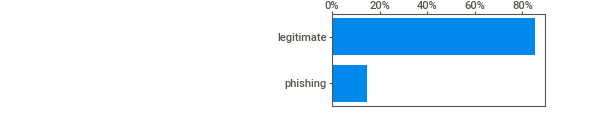
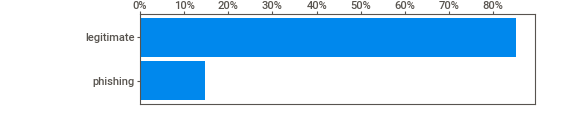
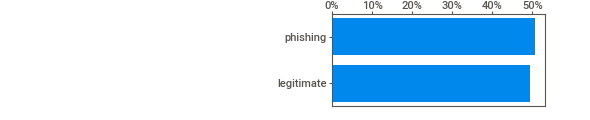
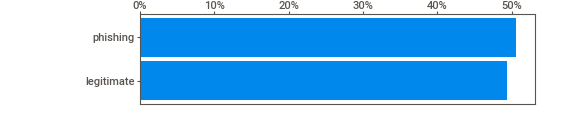
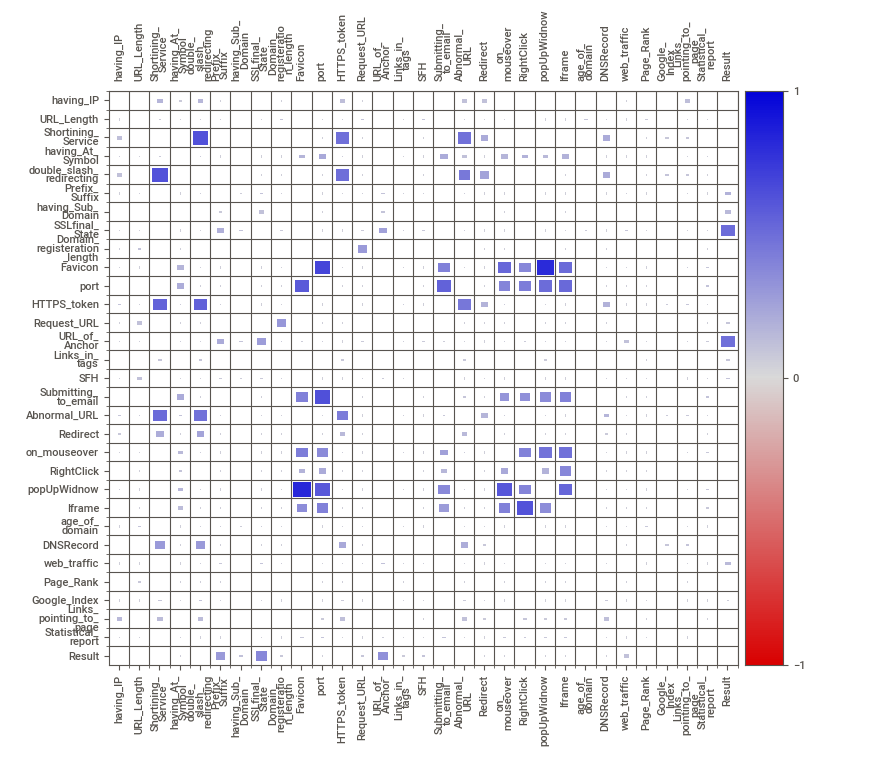
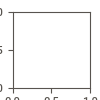

In [ ]:
# sweetviz auto eda
my_report = eda.analyze(train_unik.replace([-1, 0, 1], ["phishing", "suspicious", "legitimate"]))
my_report.show_notebook()

**Result:** Here we have `legitimate: 51%` and `phishing: 49%`. I would say this is a **nice balance** between the classes.


# Expected outcome

- As we can clearly understand that, we are dealing with a binary classification problem.

- Based on my understanding of the given problem we have build a model which can provide us the **lowest** `Recall` score.

# Prepaing Dataset

## Perform ordinal encoding to aid the training process

In [18]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

## Define `Phising=1` and `Legitimate=0`

In [19]:
train_unik.sample(5, random_state=0)

having_IP  URL_Length  Shortining_Service  having_At_Symbol  \
4027          1          -1                   1                 1   
8079         -1          -1                   1                 1   
7046         -1          -1                   1                -1   
2550         -1          -1                  -1                 1   
42            1          -1                   1                 1   

      double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  \
4027                         1             -1                  0   
8079                         1             -1                 -1   
7046                         1             -1                  0   
2550                        -1             -1                  1   
42                           1             -1                 -1   

      SSLfinal_State  Domain_registeration_length  Favicon  port  HTTPS_token  \
4027              -1                            1        1     1            1   
8079              -1                           -1       -1    -1            1   
7046               1                            1       -1    -1            1   
2550               1                           -1        1     1           -1   
42                -1                            1       -1    -1            1   

      Request_URL  URL_of_Anchor  Links_in_tags  SFH  Submitting_to_email  \
4027           -1             -1             -1   -1                    1   
8079            1             -1              0   -1                   -1   
7046           -1             -1              1   -1                   -1   
2550            1              1             -1   -1                    1   
42             -1             -1             -1   -1                   -1   

      Abnormal_URL  Redirect  on_mouseover  RightClick  popUpWidnow  Iframe  \
4027             1         0             1           1            1       1   
8079             1         0             1           1           -1       1   
7046             1         0            -1           1           -1      -1   
2550            -1         1             1           1            1       1   
42              -1         0            -1           1           -1       1   

      age_of_domain  DNSRecord  web_traffic  Page_Rank  Google_Index  \
4027             -1         -1            0         -1             1   
8079              1          1            0         -1            -1   
7046              1          1            1         -1            -1   
2550              1         -1            1         -1             1   
42               -1         -1            1         -1             1   

      Links_pointing_to_page  Statistical_report  Result  
4027                       0                   1      -1  
8079                       0                   1      -1  
7046                       1                   1      -1  
2550                       1                   1       1  
42                        -1                  -1      -1

In [20]:
# conver (-1 to 1) and (1 to 0) [WARNING!! run this only once]
train_unik["Result"] = train_unik["Result"].apply(lambda x: 1 if x is -1 else 0)
train_unik.sample(5, random_state=0)

having_IP  URL_Length  Shortining_Service  having_At_Symbol  \
4027          1          -1                   1                 1   
8079         -1          -1                   1                 1   
7046         -1          -1                   1                -1   
2550         -1          -1                  -1                 1   
42            1          -1                   1                 1   

      double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  \
4027                         1             -1                  0   
8079                         1             -1                 -1   
7046                         1             -1                  0   
2550                        -1             -1                  1   
42                           1             -1                 -1   

      SSLfinal_State  Domain_registeration_length  Favicon  port  HTTPS_token  \
4027              -1                            1        1     1            1   
8079              -1                           -1       -1    -1            1   
7046               1                            1       -1    -1            1   
2550               1                           -1        1     1           -1   
42                -1                            1       -1    -1            1   

      Request_URL  URL_of_Anchor  Links_in_tags  SFH  Submitting_to_email  \
4027           -1             -1             -1   -1                    1   
8079            1             -1              0   -1                   -1   
7046           -1             -1              1   -1                   -1   
2550            1              1             -1   -1                    1   
42             -1             -1             -1   -1                   -1   

      Abnormal_URL  Redirect  on_mouseover  RightClick  popUpWidnow  Iframe  \
4027             1         0             1           1            1       1   
8079             1         0             1           1           -1       1   
7046             1         0            -1           1           -1      -1   
2550            -1         1             1           1            1       1   
42              -1         0            -1           1           -1       1   

      age_of_domain  DNSRecord  web_traffic  Page_Rank  Google_Index  \
4027             -1         -1            0         -1             1   
8079              1          1            0         -1            -1   
7046              1          1            1         -1            -1   
2550              1         -1            1         -1             1   
42               -1         -1            1         -1             1   

      Links_pointing_to_page  Statistical_report  Result  
4027                       0                   1       1  
8079                       0                   1       1  
7046                       1                   1       1  
2550                       1                   1       0  
42                        -1                  -1       1

## Prepare `X` and `y`

In [21]:
# prepare variables
X = train_unik.drop(columns=["Result"])
y = train_unik.Result

## Ordinal Encoding

In [22]:
# encoder pipeline
enc = Pipeline(steps=[
    ("encoder", OrdinalEncoder()),
])
# perform ordinal encoding
enc_arr = enc.fit_transform(X)
X = X.copy()
# encode
X.loc[:,:] = enc_arr

# prepare test data
# drop key column
test_key = test['key']
test.drop(columns=['key'], inplace=True)
# perform ordinal encoding
enc_test_arr = enc.transform(test)
test_enc = test.copy()
# encode
test_enc.loc[:,:] = enc_test_arr
test_enc.head()

having_IP  URL_Length  Shortining_Service  having_At_Symbol  \
0        1.0         2.0                 1.0               1.0   
1        1.0         0.0                 1.0               1.0   
2        1.0         0.0                 1.0               1.0   
3        0.0         0.0                 0.0               1.0   
4        1.0         0.0                 1.0               1.0   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                       1.0            1.0                0.0             2.0   
1                       1.0            0.0                1.0             0.0   
2                       1.0            0.0                1.0             1.0   
3                       0.0            0.0                0.0             0.0   
4                       1.0            0.0                2.0             2.0   

   Domain_registeration_length  Favicon  port  HTTPS_token  Request_URL  \
0                          0.0      1.0   1.0          1.0          1.0   
1                          1.0      1.0   1.0          1.0          1.0   
2                          0.0      0.0   0.0          1.0          0.0   
3                          1.0      0.0   0.0          0.0          0.0   
4                          0.0      1.0   1.0          1.0          1.0   

   URL_of_Anchor  Links_in_tags  SFH  Submitting_to_email  Abnormal_URL  \
0            1.0            1.0  2.0                  1.0           1.0   
1            0.0            0.0  0.0                  1.0           1.0   
2            0.0            0.0  0.0                  0.0           1.0   
3            0.0            2.0  0.0                  0.0           0.0   
4            1.0            2.0  0.0                  1.0           1.0   

   Redirect  on_mouseover  RightClick  popUpWidnow  Iframe  age_of_domain  \
0       0.0           1.0         1.0          1.0     1.0            1.0   
1       0.0           1.0         1.0          1.0     1.0            0.0   
2       0.0           0.0         0.0          0.0     0.0            1.0   
3       1.0           0.0         1.0          0.0     0.0            1.0   
4       0.0           1.0         1.0          1.0     1.0            1.0   

   DNSRecord  web_traffic  Page_Rank  Google_Index  Links_pointing_to_page  \
0        1.0          2.0        1.0           0.0                     1.0   
1        0.0          1.0        0.0           0.0                     1.0   
2        0.0          2.0        0.0           1.0                     2.0   
3        0.0          2.0        0.0           1.0                     2.0   
4        1.0          2.0        0.0           1.0                     1.0   

   Statistical_report  
0                 1.0  
1                 1.0  
2                 0.0  
3                 0.0  
4                 1.0

# Dominant Features Selection

As per my last result we have the following 8 top features:

1. `having_IP`,
1. `Google_Index`,
1. `SFH`,
1. `Links_pointing_to_page`
1. `URL_of_Anchor`,
1. `Request_URL`,
1. `Links_in_tags`,
1. `SSLfinal_State`

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [24]:
import sklearn
from sklearn.feature_selection import RFE
import time, datetime
# save model to a file
import joblib
import os
from sklearn.model_selection import train_test_split

## Finding the dominant features

With `RFECV` and manual feature elimination we found below **top 8 predictors**

In [25]:
feature_cols = ["having_IP",
"Google_Index",
"SFH",
"Links_pointing_to_page",
"URL_of_Anchor",
"Request_URL",
"Links_in_tags",
"SSLfinal_State"]

In [ ]:
# build model
np.random.seed(42)
X_train_sm_ = sm.add_constant(X[feature_cols])
algo_ = sm.GLM(y, X_train_sm_, family = sm.families.Binomial())
logm2_ = algo_.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
logm2_.params.sort_values()

URL_of_Anchor            -3.001796
SSLfinal_State           -1.607724
Google_Index             -0.996150
Request_URL              -0.821899
SFH                      -0.801168
Links_in_tags            -0.764746
Links_pointing_to_page   -0.625070
having_IP                -0.528964
const                     8.096372
dtype: float64

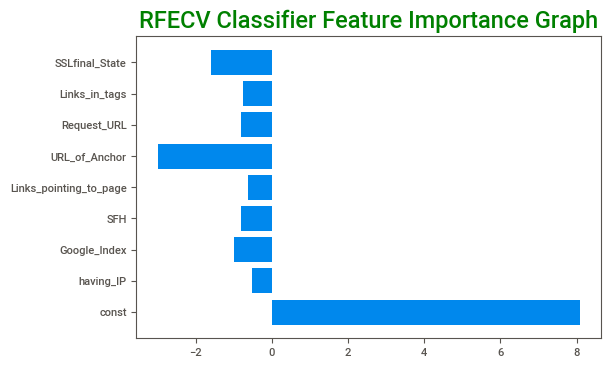

In [ ]:
plt.title("RFECV Classifier Feature Importance Graph", fontdict=fontdict  )
plt.barh(logm2_.params.index, logm2_.params.values)
plt.show()

According to the above information top two featrues are as follows:

- `URL_of_Anchor`:            -3.001796
- `SSLfinal_State`:           -1.607724

# Top features with `XGBoost`

In [26]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb


In [ ]:
# best XGB Classifier as per my last experiment
xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42,
                              scoring="auc",
                              learning_rate=0.05,
                              max_depth=7,
                              n_estimators=133,
                              subsample=0.9
                            )

In [ ]:
xgb_res = xgb_model.fit(X, y)

### XBG feature importance

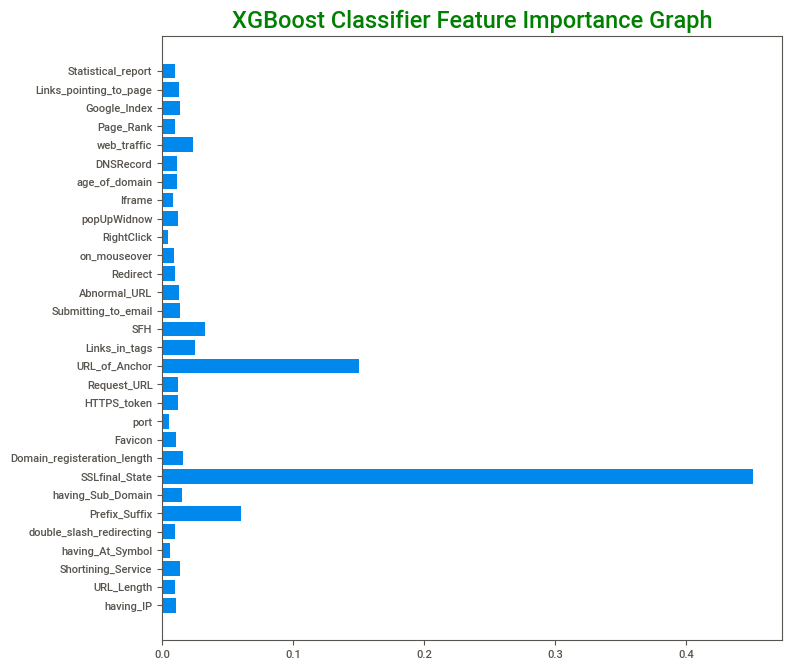

In [ ]:
plt.figure(figsize=[8, 8])
plt.title("XGBoost Classifier Feature Importance Graph", fontdict=fontdict  )
plt.barh(X.columns, xgb_model.feature_importances_)
plt.show()

## Dominant Features

As per our previous two, RFECV and XGBClassifier, analysis we can conclude that top two dominant featrues are as follows:

1. `SSLfinal_State`
1. `URL_of_Anchor`

## Droping Dominant Features

In [27]:
X2 = X.drop(columns=["SSLfinal_State", "URL_of_Anchor"])
test2 = test_enc.drop(columns=["SSLfinal_State", "URL_of_Anchor"])

In [ ]:
# stop here

# Model Building (Decision Trees)

As we already have a decent idea on models from our previous case-study, we shall directly start with Hyperparameter Optimization:

## Hyperparameter Tuning (**Grid Search CV**)

In [ ]:
# decision tree parameter grids
parameters = {'criterion':['gini', 'entropy'],
              'max_depth':[3, 5, 10, 15, 40],
              'min_samples_leaf' : [2, 5, 10, 15],
              'min_samples_split' : [2, 10, 25, 30],
              'max_features' : ['auto', 'log2'],
            }

# prepare grid search object
dt1 = DecisionTreeClassifier(random_state=0, class_weight='balanced')
gridcv_dt = GridSearchCV(dt1, parameters, 
                        cv=5, 
                        scoring = ['roc_auc', 'accuracy', 'recall', 'precision', 'neg_log_loss'], refit='roc_auc',
                        error_score='raise', verbose=2, return_train_score=True)

In [ ]:
# Perform the grid search
res_gridcv_dt = gridcv_dt.fit(X2, y)
# save the model
dump(gridcv_dt, root % 'gridcv_dt.joblib')
dump(res_gridcv_dt, root % 'res_gridcv_dt.joblib')

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.

['/content/drive/MyDrive/TechGig_HPE_ML_2022/HPE_Machine_Learning_Hackathon_CG_2022/Final/res_gridcv_dt.joblib']

In [ ]:
# # load the model
# gridcv_dt = load(root % 'gridcv_dt.joblib')
# res_gridcv_dt = load(root % 'res_gridcv_dt.joblib')

In [ ]:
# best model
gridcv_dt.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, max_features='auto', min_samples_leaf=5,
                       min_samples_split=30, random_state=0)

In [ ]:
# best score
gridcv_dt.best_score_

0.8574426587962861

### Search Summary

In [ ]:
# grid search result
cvdf = pd.DataFrame(gridcv_dt.cv_results_)

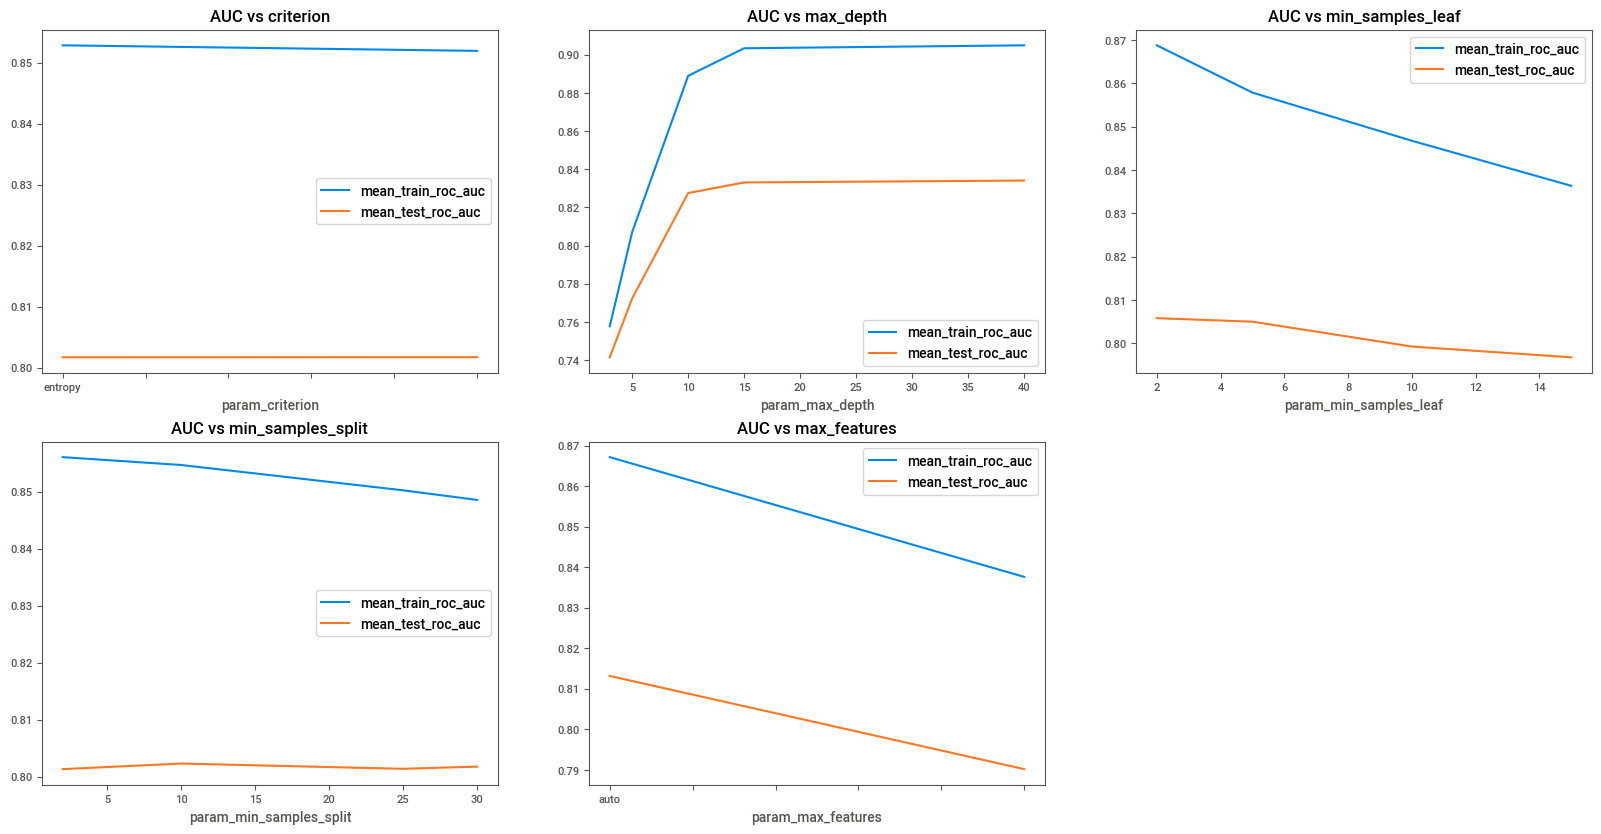

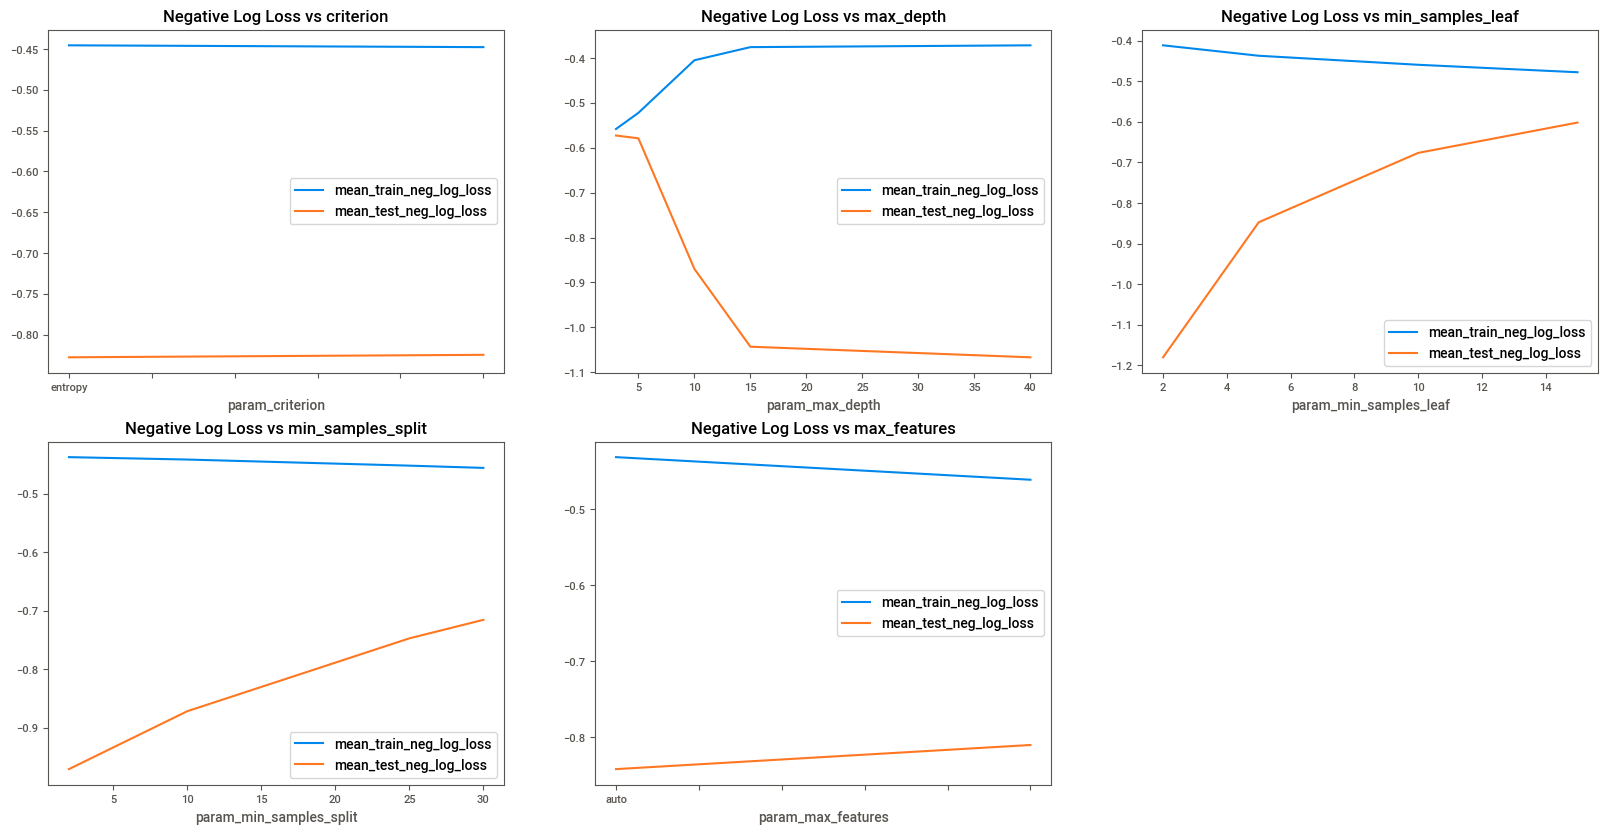

In [ ]:
# grid search performance plots
features = parameters.keys()
plt.figure(figsize=(20, 10))
display(HTML('<b>ROC_AUC</b>'))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_roc_auc', 'mean_test_roc_auc'].mean().plot(ax=ax)
    ax.set_title("AUC vs %s"%f)
plt.show()
features = parameters.keys()
plt.figure(figsize=(20, 10))
display(HTML('<b>Negative Loss</b>'))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_neg_log_loss', 'mean_test_neg_log_loss'].mean().plot(ax=ax)
    ax.set_title("Negative Log Loss vs %s"%f)
plt.show()

## Finetuning - **Grid Search CV**

In [32]:
# decision tree parameter grids
parameters = {'max_depth':range(9, 16)}

# prepare grid search object
dt2 = DecisionTreeClassifier(random_state=0, 
                             class_weight='balanced',
                             criterion='entropy',
                             max_features='log2',
                             min_samples_leaf=2,
                             min_samples_split=2,
                            )
gridcv_dt2 = GridSearchCV(dt2, parameters, cv=5, 
                        scoring = ['roc_auc', 'accuracy', 'recall', 'precision', 'neg_log_loss'], 
                        refit='roc_auc',
                        error_score='raise', verbose=2, return_train_score=True)

In [33]:
# Perform the grid search
res_gridcv_dt2 = gridcv_dt2.fit(X2, y)
dump(gridcv_dt2, root % 'gridcv_dt2.joblib')
dump(res_gridcv_dt2, root % 'res_gridcv_dt2.joblib')

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ........................................max_depth=9; total time=   0.0s
[CV] END ........................................max_depth=9; total time=   0.0s
[CV] END ........................................max_depth=9; total time=   0.0s
[CV] END ........................................max_depth=9; total time=   0.0s
[CV] END ........................................max_depth=9; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=11; total time=   0.0s
[CV] END .......................................m

['/content/drive/MyDrive/TechGig_HPE_ML_2022/HPE_Machine_Learning_Hackathon_CG_2022/Final/res_gridcv_dt2.joblib']

In [ ]:
# load the model
# gridcv_dt2 = load(root % 'gridcv_dt2.joblib')
# res_gridcv_dt2 = load(root % 'res_gridcv_dt2.joblib')

In [ ]:
# best model
gridcv_dt2.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features='log2', min_samples_leaf=4,
                       random_state=0)

In [ ]:
# best score
# (0.971056927810557, 0.9559734759860726)
gridcv_dt.best_score_, gridcv_dt2.best_score_

(0.8574426587962861, 0.8498911821369497)

In [ ]:
# grid search result
cvdf = pd.DataFrame(gridcv_dt2.cv_results_)
cvdf.head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.025070      0.010367         0.028625        0.007616   
1       0.026256      0.009979         0.031853        0.009365   

  param_max_depth             params  split0_test_roc_auc  \
0               9   {'max_depth': 9}             0.825989   
1              10  {'max_depth': 10}             0.848590   

   split1_test_roc_auc  split2_test_roc_auc  split3_test_roc_auc  \
0             0.867823             0.854367             0.834972   
1             0.847558             0.881561             0.868719   

   split4_test_roc_auc  mean_test_roc_auc  std_test_roc_auc  \
0             0.786949           0.834020          0.027705   
1             0.801540           0.849593          0.027210   

   rank_test_roc_auc  split0_train_roc_auc  split1_train_roc_auc  \
0                  6              0.910859              0.891057   
1                  2              0.922261              0.908563   

   split2_train_roc_auc  split3_train_roc_auc  split4_train_roc_auc  \
0              0.887998              0.892890              0.918623   
1              0.921369              0.916252              0.939238   

   mean_train_roc_auc  std_train_roc_auc  split0_test_accuracy  \
0            0.900285           0.012157              0.779482   
1            0.921537           0.010101              0.788111   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.813039              0.767977              0.751678   
1              0.772771              0.804410              0.811122   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.751440            0.772723           0.022757   
1              0.708253            0.776934           0.036832   

   rank_test_accuracy  split0_train_accuracy  split1_train_accuracy  \
0                   3               0.824503               0.803884   
1                   2               0.840326               0.811796   

   split2_train_accuracy  split3_train_accuracy  split4_train_accuracy  \
0               0.789978               0.803404               0.835570   
1               0.828578               0.832654               0.857143   

   mean_train_accuracy  std_train_accuracy  split0_test_recall  \
0             0.811468            0.016341            0.857955   
1             0.834099            0.014831            0.804924   

   split1_test_recall  split2_test_recall  split3_test_recall  \
0            0.857955            0.768939            0.729167   
1            0.846591            0.818182            0.784091   

   split4_test_recall  mean_test_recall  std_test_recall  rank_test_recall  \
0            0.719165          0.786636         0.060565                 2   
1            0.726755          0.796109         0.040169                 1   

   split0_train_recall  split1_train_recall  split2_train_recall  \
0             0.830886             0.852203             0.790621   
1             0.832307             0.852203             0.825675   

   split3_train_recall  split4_train_recall  mean_train_recall  \
0             0.812411             0.845170           0.826258   
1             0.831833             0.890625           0.846529   

   std_train_recall  split0_test_precision  split1_test_precision  \
0          0.022423               0.745066               0.790576   
1          0.023790               0.782689               0.741294   

   split2_test_precision  split3_test_precision  split4_test_precision  \
0               0.771863               0.768463               0.773469   
1               0.800000               0.832998               0.705341   

   mean_test_precision  std_test_precision  rank_test_precision  \
0             0.769887            0.014580                    5   
1             0.772464            0.044731                    4   

   split0_train_precision  split1_train_precision  split2_train_precision  \
0         

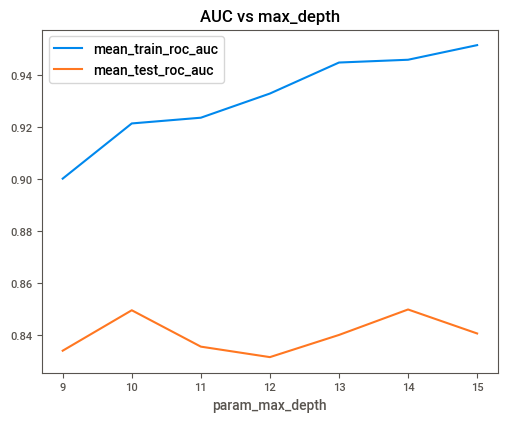

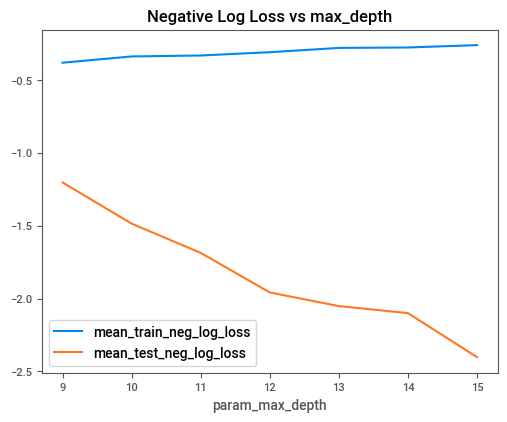

In [ ]:
# grid search performance plots
features = parameters.keys()
plt.figure(figsize=(20, 10))
display(HTML('<b>ROC_AUC</b>'))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_roc_auc', 'mean_test_roc_auc'].mean().plot(ax=ax)
    ax.set_title("AUC vs %s"%f)
plt.show()
features = parameters.keys()
plt.figure(figsize=(20, 10))
display(HTML('<b>Negative Loss</b>'))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_neg_log_loss', 'mean_test_neg_log_loss'].mean().plot(ax=ax)
    ax.set_title("Negative Log Loss vs %s"%f)
plt.show()

1. Loss is minimum when `"max_depth"` is `15`, but ROC_AUC is high for `max_depth=14`

In [ ]:
# decision tree with fine-tuned hyperparameters parameters
dt3 = DecisionTreeClassifier(random_state=0, 
                             class_weight='balanced',
                             criterion='entropy',
                             max_features='log2',
                             min_samples_leaf=2,
                             min_samples_split=2,
                             max_depth=14,
                            )

In [ ]:
# fit and save the model and results
res_dt3 = dt3.fit(X2, y)
# save the model
dump(dt3, root % 'dt3.joblib')
dump(res_dt3, root % 'res_dt3.joblib')

['/content/drive/MyDrive/TechGig_HPE_ML_2022/HPE_Machine_Learning_Hackathon_CG_2022/Final/res_dt3.joblib']

In [ ]:
# # load the model
# dt3 = load(root % 'dt3.joblib')
# res_dt3 = load(root % 'res_dt3.joblib')

## Feature Importance

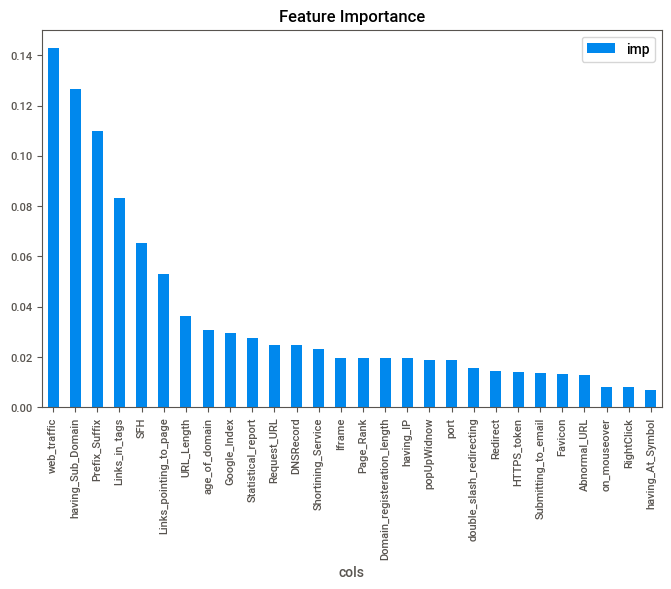

In [ ]:
# feature importance
fdf = pd.DataFrame(dict(imp=dt3.feature_importances_, cols=X2.columns))\
            .sort_values(by="imp", ascending=False)
fdf.plot.bar(x='cols', title="Feature Importance", figsize=[8, 5])
plt.show()

In [ ]:
# top 5 features
fdf.head()

imp               cols
23  0.142996        web_traffic
6   0.126693  having_Sub_Domain
5   0.109939      Prefix_Suffix
12  0.083202      Links_in_tags
13  0.065257                SFH

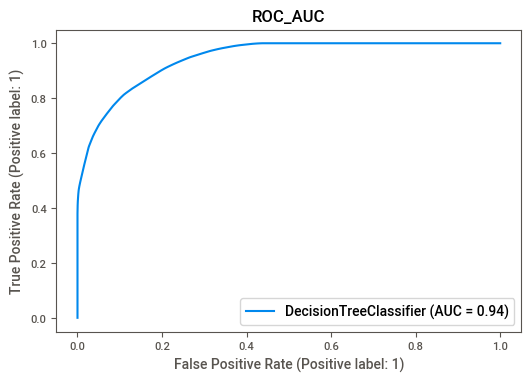

In [ ]:
# ROC - AUC
from sklearn import metrics 

metrics.plot_roc_curve(dt3, X2, y)
plt.title("ROC_AUC")
plt.show()

## Finding the probability cutoff

In [ ]:
# calculate probability values
y_train_proba =pd.Series(dt3.predict_proba(X2)[:, 1])

# prepare a dataframe
y_train_final = pd.DataFrame(columns=['phishing', 'proba'])

y_train_final['phishing'] = np.array(y)
y_train_final['proba'] = y_train_proba
# calculate prediction for different probability values
cutoff_range= np.arange(0, 1.001, 0.001)
for i in cutoff_range:
    y_train_final[f"{round(i,2)}"] = y_train_proba.apply(lambda x: 1 if x >= i else 0)
y_train_final.head()


phishing     proba  0.0  0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  \
0         1  0.661189    1     1     1     1     1     1     1     1     1   
1         1  1.000000    1     1     1     1     1     1     1     1     1   
2         1  0.661189    1     1     1     1     1     1     1     1     1   
3         1  0.163285    1     1     1     1     1     1     1     1     1   
4         0  0.860085    1     1     1     1     1     1     1     1     1   

   0.09  0.1  0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2  0.21  \
0     1    1     1     1     1     1     1     1     1     1     1    1     1   
1     1    1     1     1     1     1     1     1     1     1     1    1     1   
2     1    1     1     1     1     1     1     1     1     1     1    1     1   
3     1    1     1     1     1     1     1     0     0     0     0    0     0   
4     1    1     1     1     1     1     1     1     1     1     1    1     1   

   0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3  0.31  0.32  0.33  \
0     1     1     1     1     1     1     1     1    1     1     1     1   
1     1     1     1     1     1     1     1     1    1     1     1     1   
2     1     1     1     1     1     1     1     1    1     1     1     1   
3     0     0     0     0     0     0     0     0    0     0     0     0   
4     1     1     1     1     1     1     1     1    1     1     1     1   

   0.34  0.35  0.36  0.37  0.38  0.39  0.4  0.41  0.42  0.43  0.44  0.45  \
0     1     1     1     1     1     1    1     1     1     1     1     1   
1     1     1     1     1     1     1    1     1     1     1     1     1   
2     1     1     1     1     1     1    1     1     1     1     1     1   
3     0     0     0     0     0     0    0     0     0     0     0     0   
4     1     1     1     1     1     1    1     1     1     1     1     1   

   0.46  0.47  0.48  0.49  0.5  0.51  0.52  0.53  0.54  0.55  0.56  0.57  \
0     1     1     1     1    1     1     1     1     1     1     1     1   
1     1     1     1     1    1     1     1     1     1     1     1     1   
2     1     1     1     1    1     1     1     1     1     1     1     1   
3     0     0     0     0    0     0     0     0     0     0     0     0   
4     1     1     1     1    1     1     1     1     1     1     1     1   

   0.58  0.59  0.6  0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7  \
0     1     1    1     1     1     1     1     1     0     0     0     0    0   
1     1     1    1     1     1     1     1     1     1     1     1     1    1   
2     1     1    1     1     1     1     1     1     0     0     0     0    0   
3     0     0    0     0     0     0     0     0     0     0     0     0    0   
4     1     1    1     1     1     1     1     1     1     1     1     1    1   

   0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8  0.81  0.82  \
0     0     0     0     0     0     0     0     0     0    0     0     0   
1     1     1     1     1     1     1     1     1     1    1     1     1   
2     0     0     0     0     0     0     0     0     0    0     0     0   
3     0     0     0     0     0     0     0     0     0    0     0     0   
4     1     1     1     1     1     1     1     1     1    1     1     1   

   0.83  0.84  0.85  0.86  0.87  0.88  0.89  0.9  0.91  0.92  0.93  0.94  \
0     0     0     0     0     0     0     0    0     0     0     0     0   
1     1     1     1     1     1     1     1    1     1     1     1     1   
2     0     0     0     0     0     0     0    0     0     0     0     0   
3     0     0     0     0     0     0     0    0     0     0     0     0   
4     1     1     1     0     0     0     0    0     0     0     0     0   

   0.95  0.96  0.97  0.98  0.99  1.0  
0     0     0     0     0     0    0  
1     1     1     1     1     1    1  
2     0     0     0     0     0    0  
3     0     0     0     0     0    0  
4     0     0     0     0     0    0

In [ ]:
# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['cutoff', 'accuracy', 'sensi', 'speci','false negative rate', 'false positive rate'])
for i in cutoff_range:
    cm1 = metrics.confusion_matrix(y_train_final["phishing"], y_train_final[f"{round(i,2)}"] )
    total1=sum(sum(cm1))
    # metrics
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    false_negative_rate = 1-sensi
    false_positive_rate = 1-speci
    # update dataframe
    cutoff_df.loc[i] =[i, accuracy, sensi, speci, false_negative_rate, false_positive_rate]
cutoff_df.sample(10)

cutoff  accuracy     sensi     speci  false negative rate  \
0.521   0.521  0.851554  0.818871  0.885049             0.181129   
0.941   0.941  0.721327  0.451307  0.998058             0.548693   
0.741   0.741  0.823360  0.699128  0.950680             0.300872   
0.980   0.980  0.701189  0.410004  0.999612             0.589996   
0.411   0.411  0.849444  0.923077  0.773981             0.076923   
0.679   0.679  0.828922  0.717696  0.942913             0.282304   
0.673   0.673  0.835827  0.743463  0.930485             0.256537   
0.513   0.513  0.852512  0.835165  0.870291             0.164835   
0.773   0.773  0.809743  0.659341  0.963883             0.340659   
0.136   0.136  0.803414  0.994316  0.607767             0.005684   

       false positive rate  
0.521             0.114951  
0.941             0.001942  
0.741             0.049320  
0.980             0.000388  
0.411             0.226019  
0.679             0.057087  
0.673             0.069515  
0.513             0.129709  
0.773             0.036117  
0.136             0.392233

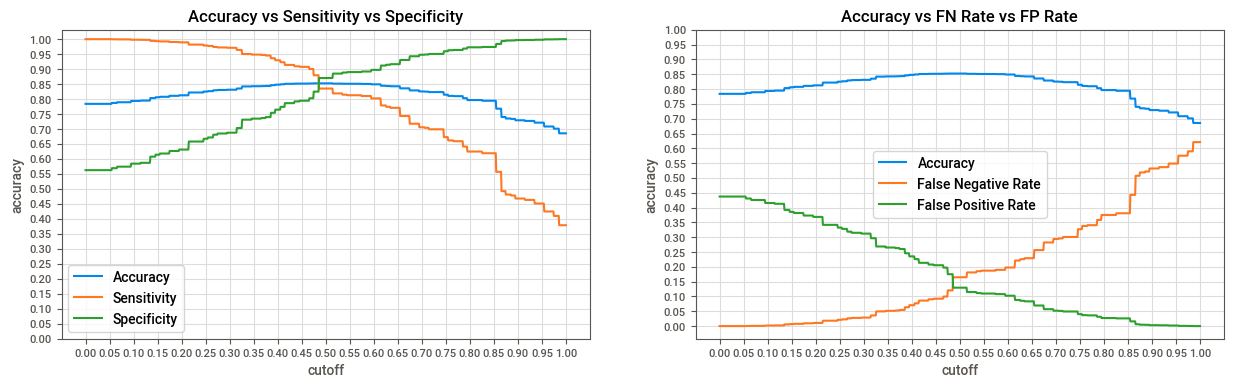

In [ ]:
# metric comparison polt
plt.figure(figsize=[15, 9])
ax = plt.subplot(2,2,1)
ax.set_title("Accuracy vs Sensitivity vs Specificity")
sns.lineplot(data=cutoff_df, x="cutoff", y="accuracy", label="Accuracy")
sns.lineplot(data=cutoff_df, x="cutoff", y="sensi", label="Sensitivity")
sns.lineplot(data=cutoff_df, x="cutoff", y="speci", label="Specificity")
ax.set_xticks(np.arange(0, 1.05, 0.05))
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.grid(visible=True, color="#dddddd")
ax = plt.subplot(2,2,2)
ax.set_title("Accuracy vs FN Rate vs FP Rate")
sns.lineplot(data=cutoff_df, x="cutoff", y="accuracy", label="Accuracy")
sns.lineplot(data=cutoff_df, x="cutoff", y="false negative rate", label="False Negative Rate")
sns.lineplot(data=cutoff_df, x="cutoff", y="false positive rate", label="False Positive Rate")
ax.grid(visible=True, color="#dddddd")
ax.set_xticks(np.arange(0, 1.05, 0.05))
ax.set_yticks(np.arange(0, 1.05, 0.05))
plt.show()

### Optimal `probability cutoff` for prediction

In [ ]:
# optimal cutoff finding
closest = np.argmin(np.array(cutoff_df["false positive rate"] - cutoff_df["false negative rate"])**2)
optimal = pd.DataFrame(cutoff_df.iloc[closest]).T
optimal

cutoff  accuracy     sensi     speci  false negative rate  \
0.486   0.486  0.852512  0.835165  0.870291             0.164835   

       false positive rate  
0.486             0.129709

In [ ]:
# optimal values
optimal = round(optimal, 3)
print("Optimal Probability cutoff: ", optimal['cutoff'].values)
print("Accuracy at optimal cutoff: ", optimal['accuracy'].values)
print("Sensitivity at optimal cutoff: ", optimal['sensi'].values)
print("Specificity at optimal cutoff: ", optimal['speci'].values)
print("FNR at optimal cutoff: ", optimal['false negative rate'].values)
print("FPR at optimal cutoff: ", optimal['false positive rate'].values)

Optimal Probability cutoff:  [0.486]
Accuracy at optimal cutoff:  [0.853]
Sensitivity at optimal cutoff:  [0.835]
Specificity at optimal cutoff:  [0.87]
FNR at optimal cutoff:  [0.165]
FPR at optimal cutoff:  [0.13]


## Analytics Decision on `cutoff`

- As we want to correctly predict the `phising` site, we should keep the **`FNR`** to **as low as possible**.
- While considering the **Accuracy** in mind, which is `~85%`

In [ ]:
# choose a cutoff = 0.25
my_options = pd.DataFrame(cutoff_df.loc[0.4]).T
my_options

cutoff  accuracy     sensi    speci  false negative rate  \
0.4     0.4  0.848101  0.929519  0.76466             0.070481   

     false positive rate  
0.4              0.23534

In [ ]:
# My values
my_options = round(my_options, 3)
print("Our Probability cutoff: ", my_options['cutoff'].values)
print("Accuracy at our cutoff: ", my_options['accuracy'].values)
print("Sensitivity at our cutoff: ", my_options['sensi'].values)
print("Specificity at our cutoff: ", my_options['speci'].values)
print("FNR at our cutoff: ", my_options['false negative rate'].values)
print("FPR at our cutoff: ", my_options['false positive rate'].values)

Our Probability cutoff:  [0.4]
Accuracy at our cutoff:  [0.848]
Sensitivity at our cutoff:  [0.93]
Specificity at our cutoff:  [0.765]
FNR at our cutoff:  [0.07]
FPR at our cutoff:  [0.235]


# Model Building (**Random Forest**)

In [ ]:
# decision tree parameter grids
parameters = {'criterion':['gini', 'entropy'],
              'max_depth':[3, 4, 5, 6, 10, 15],
              'min_samples_leaf' : [1, 2, 5, 10],
              'min_samples_split' : [10, 20, 30],
              'max_features' : ['auto', 'log2'],
            }

# prepare grid search object
rf1 = RandomForestClassifier(random_state=0, class_weight='balanced')
gridcv_rf1 = GridSearchCV(rf1, parameters, cv=5,
                        scoring = ['roc_auc', 'accuracy', 'recall', 'precision'], refit='roc_auc',
                        error_score='raise', verbose=2, return_train_score=True)

In [ ]:
# Perform the grid search
res_gridcv_rf1 = gridcv_rf1.fit(X2, y)
# save the model
dump(gridcv_rf1, root % 'gridcv_rf1.joblib')
dump(res_gridcv_rf1, root % 'res_gridcv_rf1.joblib')

# grid search performance plots
cvdf = pd.DataFrame(gridcv_rf1.cv_results_)

In [ ]:
# best estimator
gridcv_rf1.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, max_features='log2', min_samples_split=10,
                       random_state=0)

In [ ]:
# best score
gridcv_rf1.best_score_

0.9267639068695839

- Random Forest is giving us better performance than Decision Tree.

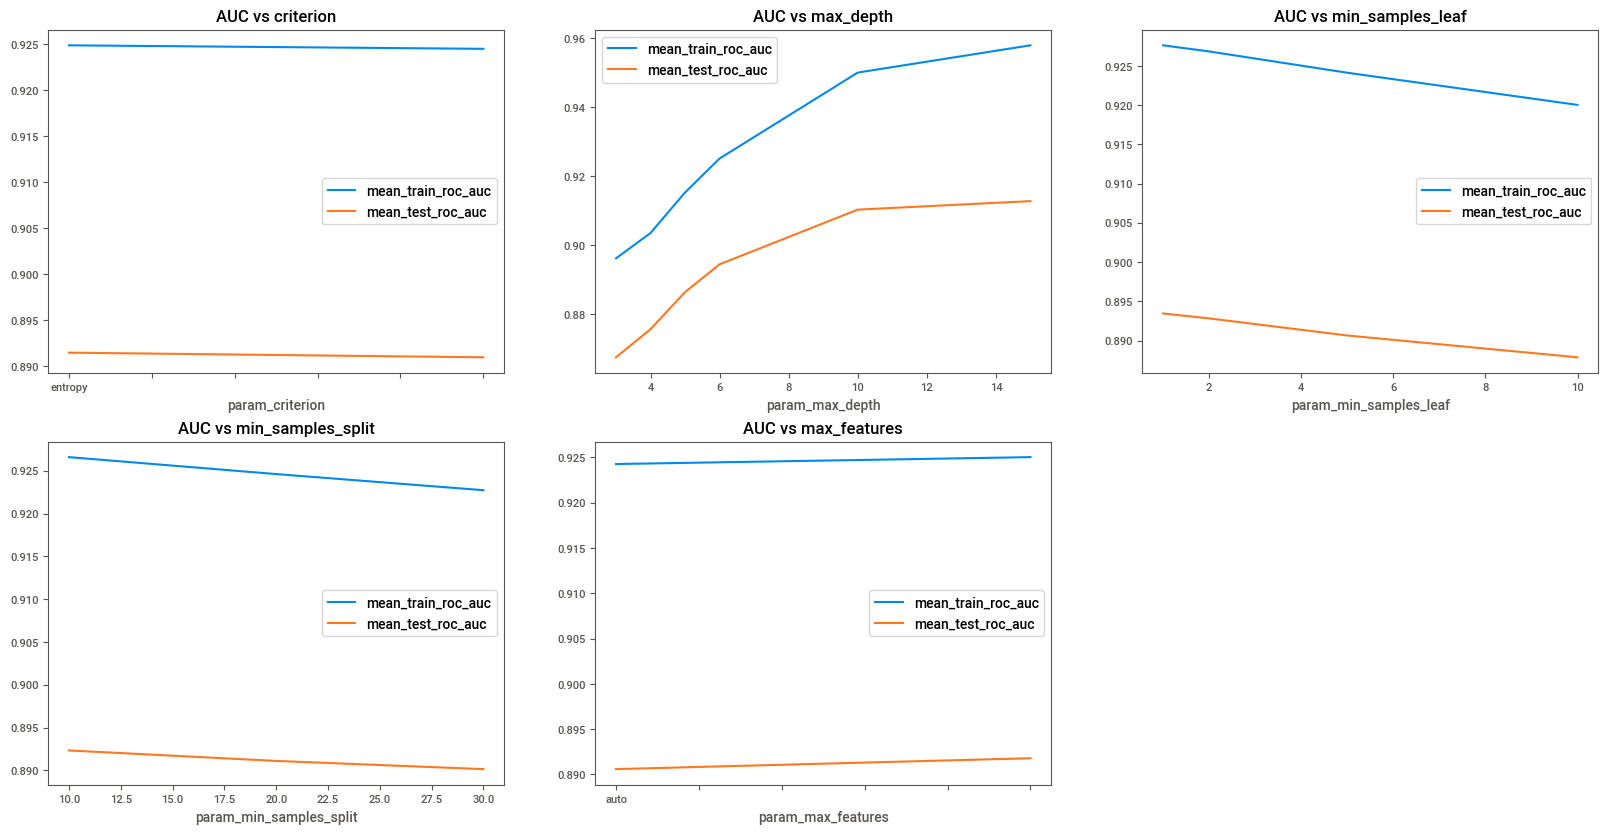

In [ ]:
# grid search performance plots
features = parameters.keys()
plt.figure(figsize=(20, 10))
display(HTML('<b>ROC_AUC</b>'))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_roc_auc', 'mean_test_roc_auc'].mean().plot(ax=ax)
    ax.set_title("AUC vs %s"%f)
plt.show()

## Finetune(**Random Forest CV**)

In [ ]:
# decision tree parameter grids
parameters = {
              'max_depth': range(13, 20),
              'min_samples_split' : range(2, 12)
            }

# prepare grid search object
rf2 = RandomForestClassifier(random_state=0, class_weight='balanced',
                            criterion='entropy',
                            max_features='log2',
                            min_samples_leaf=2,
                            )
gridcv_rf2 = RandomizedSearchCV(rf2, 
                                param_distributions=parameters, cv=5, 
                                n_iter=200,
                        scoring = ['roc_auc', 'accuracy', 'recall', 'precision'], refit='roc_auc',
                        error_score='raise', verbose=2, return_train_score=True)

In [ ]:
# Perform the grid search
res_gridcv_rf2 = gridcv_rf2.fit(X2, y)
# save the model
dump(gridcv_rf2, root % 'gridcv_rf2.joblib')
dump(res_gridcv_rf2, root % 'res_gridcv_rf2.joblib')
# grid search result
cvdf = pd.DataFrame(gridcv_rf2.cv_results_)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV] END ..................max_depth=13, min_samples_split=2; total time=   1.1s
[CV] END ..................max_depth=13, min_samples_split=2; total time=   1.1s
[CV] END ..................max_depth=13, min_samples_split=2; total time=   0.8s
[CV] END ..................max_depth=13, min_samples_split=2; total time=   0.7s
[CV] END ..................max_depth=13, min_samples_split=2; total time=   0.7s
[CV] END ..................max_depth=13, min_samples_split=3; total time=   0.8s
[CV] END ..................max_depth=13, min_samples_split=3; total time=   0.8s
[CV] END ..................max_depth=13, min_samples_split=3; total time=   0.8s
[CV] END ..................max_depth=13, min_samples_split=3; total time=   0.7s
[CV] END ..................max_depth=13, min_samples_split=3; total time=   1.0s
[CV] END ..................max_depth=13, min_samples_split=4; total time=   0.9s
[CV] END ..................max_depth=13, min_sa

In [ ]:
# best model
gridcv_rf2.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, random_state=0)

In [ ]:
# best model
gridcv_rf2.best_score_

0.9269158128046368

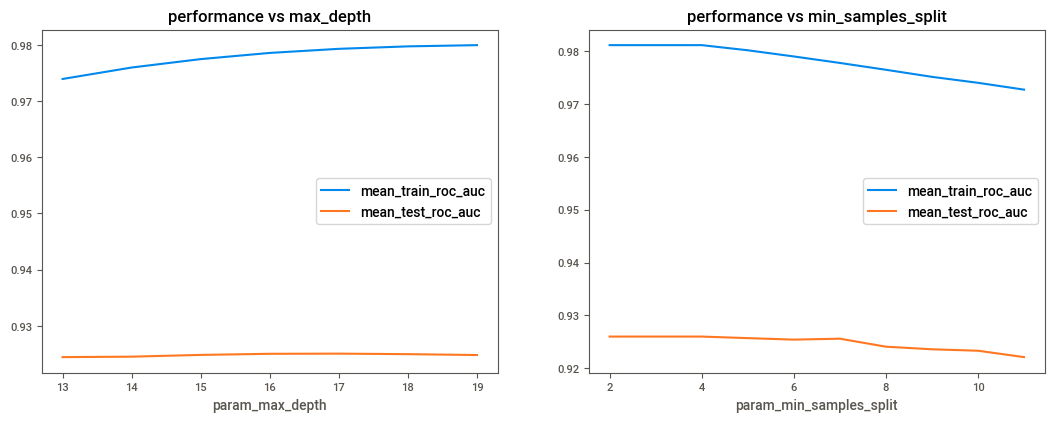

In [ ]:
# grid search performance plots
features = parameters.keys()
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    cvdf.groupby('param_%s'%f)['mean_train_roc_auc', 'mean_test_roc_auc'].mean().plot(ax=ax)
    ax.set_title("performance vs %s"%f)
plt.show()

In [109]:
# prepare grid search object
rf3 = RandomForestClassifier(random_state=0, class_weight='balanced',
                            criterion='entropy',
                            max_features='log2',
                            min_samples_leaf=2,
                            max_depth=19,
                            min_samples_split=2,
                            )
rf3.fit(X2, y)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=19, max_features='log2', min_samples_leaf=2,
                       random_state=0)

## Feature Importance

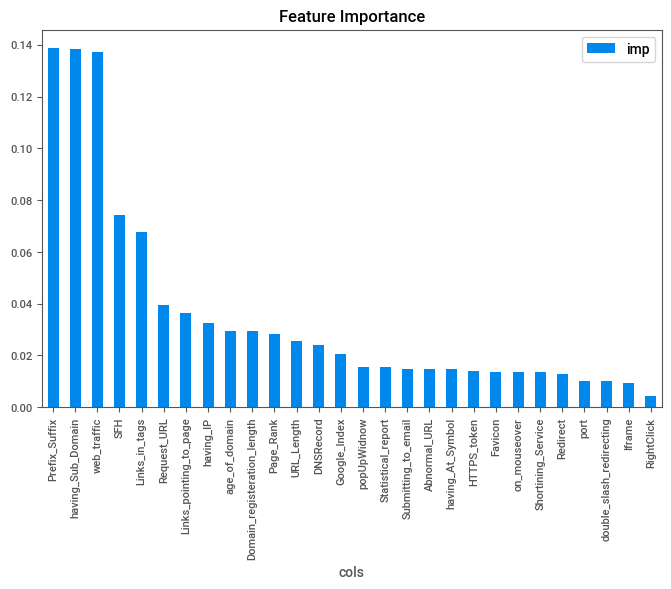

In [ ]:
# feature importance
fdf = pd.DataFrame(dict(imp=rf3.feature_importances_, cols=X2.columns))\
            .sort_values(by="imp", ascending=False)
fdf.plot.bar(x='cols', title="Feature Importance", figsize=[8, 5])
plt.show()

In [ ]:
# top 5 features
fdf.head()

imp               cols
5   0.138902      Prefix_Suffix
6   0.138499  having_Sub_Domain
23  0.137079        web_traffic
13  0.074160                SFH
12  0.067863      Links_in_tags

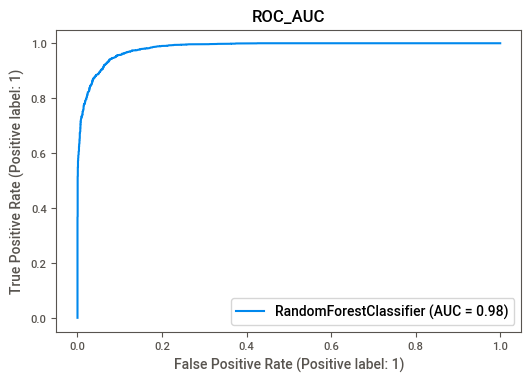

In [ ]:
# ROC - AUC
from sklearn import metrics 

metrics.plot_roc_curve(rf3, X2, y)
plt.title("ROC_AUC")
plt.show()

## Finding the probability cutoff

In [ ]:
# calculate probability values
y_train_proba =pd.Series(rf3.predict_proba(X2)[:, 1])

# prepare a dataframe
y_train_final = pd.DataFrame(columns=['phishing', 'proba'])

y_train_final['phishing'] = np.array(y)
y_train_final['proba'] = y_train_proba
# calculate prediction for different probability values
cutoff_range= np.arange(0, 1.001, 0.001)
for i in cutoff_range:
    y_train_final[f"{round(i,2)}"] = y_train_proba.apply(lambda x: 1 if x >= i else 0)
y_train_final.head()


phishing     proba  0.0  0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  \
0         1  0.845886    1     1     1     1     1     1     1     1     1   
1         1  0.943833    1     1     1     1     1     1     1     1     1   
2         1  0.687711    1     1     1     1     1     1     1     1     1   
3         1  0.690032    1     1     1     1     1     1     1     1     1   
4         0  0.292360    1     1     1     1     1     1     1     1     1   

   0.09  0.1  0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2  0.21  \
0     1    1     1     1     1     1     1     1     1     1     1    1     1   
1     1    1     1     1     1     1     1     1     1     1     1    1     1   
2     1    1     1     1     1     1     1     1     1     1     1    1     1   
3     1    1     1     1     1     1     1     1     1     1     1    1     1   
4     1    1     1     1     1     1     1     1     1     1     1    1     1   

   0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3  0.31  0.32  0.33  \
0     1     1     1     1     1     1     1     1    1     1     1     1   
1     1     1     1     1     1     1     1     1    1     1     1     1   
2     1     1     1     1     1     1     1     1    1     1     1     1   
3     1     1     1     1     1     1     1     1    1     1     1     1   
4     1     1     1     1     1     1     1     0    0     0     0     0   

   0.34  0.35  0.36  0.37  0.38  0.39  0.4  0.41  0.42  0.43  0.44  0.45  \
0     1     1     1     1     1     1    1     1     1     1     1     1   
1     1     1     1     1     1     1    1     1     1     1     1     1   
2     1     1     1     1     1     1    1     1     1     1     1     1   
3     1     1     1     1     1     1    1     1     1     1     1     1   
4     0     0     0     0     0     0    0     0     0     0     0     0   

   0.46  0.47  0.48  0.49  0.5  0.51  0.52  0.53  0.54  0.55  0.56  0.57  \
0     1     1     1     1    1     1     1     1     1     1     1     1   
1     1     1     1     1    1     1     1     1     1     1     1     1   
2     1     1     1     1    1     1     1     1     1     1     1     1   
3     1     1     1     1    1     1     1     1     1     1     1     1   
4     0     0     0     0    0     0     0     0     0     0     0     0   

   0.58  0.59  0.6  0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7  \
0     1     1    1     1     1     1     1     1     1     1     1     1    1   
1     1     1    1     1     1     1     1     1     1     1     1     1    1   
2     1     1    1     1     1     1     1     1     1     1     1     0    0   
3     1     1    1     1     1     1     1     1     1     1     1     0    0   
4     0     0    0     0     0     0     0     0     0     0     0     0    0   

   0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8  0.81  0.82  \
0     1     1     1     1     1     1     1     1     1    1     1     1   
1     1     1     1     1     1     1     1     1     1    1     1     1   
2     0     0     0     0     0     0     0     0     0    0     0     0   
3     0     0     0     0     0     0     0     0     0    0     0     0   
4     0     0     0     0     0     0     0     0     0    0     0     0   

   0.83  0.84  0.85  0.86  0.87  0.88  0.89  0.9  0.91  0.92  0.93  0.94  \
0     1     1     0     0     0     0     0    0     0     0     0     0   
1     1     1     1     1     1     1     1    1     1     1     1     0   
2     0     0     0     0     0     0     0    0     0     0     0     0   
3     0     0     0     0     0     0     0    0     0     0     0     0   
4     0     0     0     0     0     0     0    0     0     0     0     0   

   0.95  0.96  0.97  0.98  0.99  1.0  
0     0     0     0     0     0    0  
1     0     0     0     0     0    0  
2     0     0     0     0     0    0  
3     0     0     0     0     0    0  
4     0     0     0     0     0    0

In [ ]:
# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['cutoff', 'accuracy', 'sensi', 'speci','false negative rate', 'false positive rate'])
for i in cutoff_range:
    cm1 = metrics.confusion_matrix(y_train_final["phishing"], y_train_final[f"{round(i,2)}"] )
    total1=sum(sum(cm1))
    # metrics
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    false_negative_rate = 1-sensi
    false_positive_rate = 1-speci
    # update dataframe
    cutoff_df.loc[i] =[i, accuracy, sensi, speci, false_negative_rate, false_positive_rate]
cutoff_df.sample(10)

cutoff  accuracy     sensi     speci  false negative rate  \
0.093   0.093  0.706943  1.000000  0.406602             0.000000   
0.693   0.693  0.886460  0.795377  0.979806             0.204623   
0.100   0.100  0.725355  1.000000  0.443883             0.000000   
0.558   0.558  0.925010  0.910951  0.939417             0.089049   
0.972   0.972  0.522631  0.056840  1.000000             0.943160   
0.989   0.989  0.494630  0.001516  1.000000             0.998484   
0.393   0.393  0.913310  0.979538  0.845437             0.020462   
0.514   0.514  0.932681  0.942023  0.923107             0.057977   
0.485   0.485  0.930955  0.953013  0.908350             0.046987   
0.264   0.264  0.860568  0.996211  0.721553             0.003789   

       false positive rate  
0.093             0.593398  
0.693             0.020194  
0.100             0.556117  
0.558             0.060583  
0.972             0.000000  
0.989             0.000000  
0.393             0.154563  
0.514             0.076893  
0.485             0.091650  
0.264             0.278447

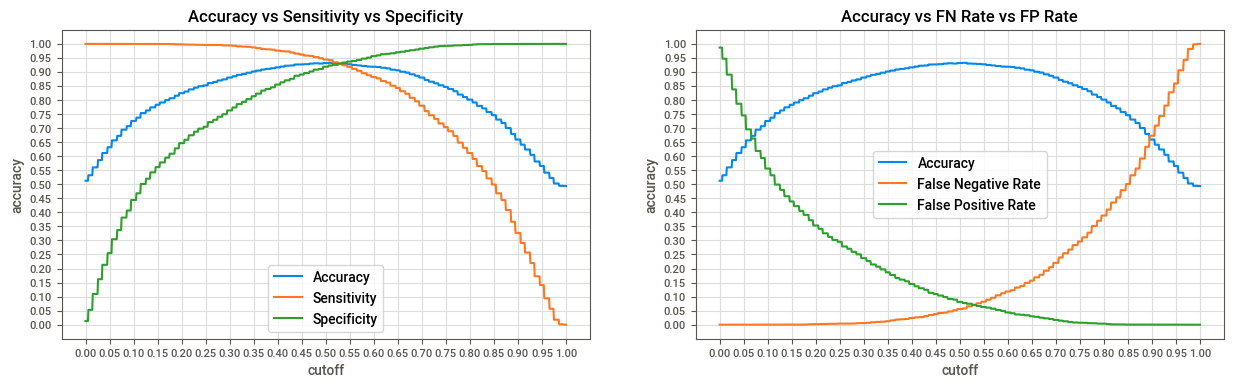

In [ ]:
# metric comparison polt
plt.figure(figsize=[15, 9])
ax = plt.subplot(2,2,1)
ax.set_title("Accuracy vs Sensitivity vs Specificity")
sns.lineplot(data=cutoff_df, x="cutoff", y="accuracy", label="Accuracy")
sns.lineplot(data=cutoff_df, x="cutoff", y="sensi", label="Sensitivity")
sns.lineplot(data=cutoff_df, x="cutoff", y="speci", label="Specificity")
ax.set_xticks(np.arange(0, 1.05, 0.05))
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.grid(visible=True, color="#dddddd")
ax = plt.subplot(2,2,2)
ax.set_title("Accuracy vs FN Rate vs FP Rate")
sns.lineplot(data=cutoff_df, x="cutoff", y="accuracy", label="Accuracy")
sns.lineplot(data=cutoff_df, x="cutoff", y="false negative rate", label="False Negative Rate")
sns.lineplot(data=cutoff_df, x="cutoff", y="false positive rate", label="False Positive Rate")
ax.grid(visible=True, color="#dddddd")
ax.set_xticks(np.arange(0, 1.05, 0.05))
ax.set_yticks(np.arange(0, 1.05, 0.05))
plt.show()

### Optimal `probability cutoff` for prediction

In [ ]:
# optimal cutoff finding
closest = np.argmin(np.array(cutoff_df["false positive rate"] - cutoff_df["false negative rate"])**2)
optimal = pd.DataFrame(cutoff_df.iloc[closest]).T
optimal

cutoff  accuracy     sensi     speci  false negative rate  \
0.526   0.526  0.929421  0.928761  0.930097             0.071239   

       false positive rate  
0.526             0.069903

In [ ]:
# optimal values
optimal = round(optimal, 3)
print("Optimal Probability cutoff: ", optimal['cutoff'].values)
print("Accuracy at optimal cutoff: ", optimal['accuracy'].values)
print("Sensitivity at optimal cutoff: ", optimal['sensi'].values)
print("Specificity at optimal cutoff: ", optimal['speci'].values)
print("FNR at optimal cutoff: ", optimal['false negative rate'].values)
print("FPR at optimal cutoff: ", optimal['false positive rate'].values)

Optimal Probability cutoff:  [0.526]
Accuracy at optimal cutoff:  [0.929]
Sensitivity at optimal cutoff:  [0.929]
Specificity at optimal cutoff:  [0.93]
FNR at optimal cutoff:  [0.071]
FPR at optimal cutoff:  [0.07]


## Analytics Decision on `cutoff`

- As we want to correctly predict the `phising` site, we should keep the **`FNR`** to **as low as possible**.
- While considering the **Accuracy** in mind, which is `~92%`

In [ ]:
# choose a cutoff
my_options = pd.DataFrame(cutoff_df.loc[0.45]).T
my_options

cutoff  accuracy     sensi     speci  false negative rate  \
0.45    0.45  0.926928  0.962107  0.890874             0.037893   

      false positive rate  
0.45             0.109126

In [ ]:
# My values
my_options = round(my_options, 3)
print("Our Probability cutoff: ", my_options['cutoff'].values)
print("Accuracy at our cutoff: ", my_options['accuracy'].values)
print("Sensitivity at our cutoff: ", my_options['sensi'].values)
print("Specificity at our cutoff: ", my_options['speci'].values)
print("FNR at our cutoff: ", my_options['false negative rate'].values)
print("FPR at our cutoff: ", my_options['false positive rate'].values)

Our Probability cutoff:  [0.45]
Accuracy at our cutoff:  [0.927]
Sensitivity at our cutoff:  [0.962]
Specificity at our cutoff:  [0.891]
FNR at our cutoff:  [0.038]
FPR at our cutoff:  [0.109]


# Model Building with **RFE** and **StatsModel**

In [58]:
import sklearn
from sklearn.feature_selection import RFE
import time, datetime
# save model to a file
import joblib
import os
from sklearn.model_selection import train_test_split

In [59]:
# build automated rfecv model in pipeline. 
# Running RFE on last model
select_feature = 13
pipeline_steps = [
    ("rfe", RFE(estimator=LogisticRegression(random_state=42), 
                n_features_to_select=select_feature,
                verbose=1,
               ))
]
# run the pipeline
rfe_reg = Pipeline(pipeline_steps, verbose=1)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [61]:
# trai frecv model
filename = f'{root}'%'rfe_reg_model.sav'
start_time = time.time()
print("Started: ", datetime.datetime.now())
# fit the model
rfe_reg.fit(X_train, y_train)
print("Ended: ", datetime.datetime.now())
print("Time took min: ", (time.time() - start_time)/60.0)
joblib.dump(rfe_reg, filename)

Started:  2022-07-23 17:03:28.908993
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
[Pipeline] ............... (step 1 of 1) Processing rfe, total=   1.2s
Ended:  2022-07-23 17:03:30.154627
Time took min:  0.02078191041946411


['/content/drive/MyDrive/TechGig_HPE_ML_2022/HPE_Machine_Learning_Hackathon_CG_2022/Final/rfe_reg_model.sav']

In [62]:
# take out the rfe instace
rfe = rfe_reg.named_steps['rfe']
rfe_df = pd.DataFrame(dict(columns=X_train.columns, consider=rfe.support_, rank=rfe.ranking_))
rfe_df = rfe_df.sort_values(by='rank', ascending=True, ignore_index=True)
rfe_df

columns  consider  rank
0                     having_IP      True     1
1                  Google_Index      True     1
2                   web_traffic      True     1
3                     DNSRecord      True     1
4                      Redirect      True     1
5        Links_pointing_to_page      True     1
6                   Request_URL      True     1
7                   HTTPS_token      True     1
8                           SFH      True     1
9            Shortining_Service      True     1
10            having_Sub_Domain      True     1
11                Prefix_Suffix      True     1
12     double_slash_redirecting      True     1
13                Links_in_tags     False     2
14           Statistical_report     False     3
15                 Abnormal_URL     False     4
16             having_At_Symbol     False     5
17                      Favicon     False     6
18                         port     False     7
19          Submitting_to_email     False     8
20  Domain_registeration_length     False     9
21                    Page_Rank     False    10
22                   RightClick     False    11
23                       Iframe     False    12
24                   URL_Length     False    13
25                age_of_domain     False    14
26                 on_mouseover     False    15
27                  popUpWidnow     False    16

- Though `RFE` has given us 13 best features
- We can clearly see:
  - Too many features
  - The features are highly correlated
- **We shall perform p-Value and VIF  analysis to reduce number of features.**
- Before doing that let us have a look at the features details and their ranks

In [63]:
# take the top features
support_cols = rfe_df[rfe_df.consider]
var_list = support_cols['columns'].values.tolist()
# save frecv features to a file
with open("rfe_features.txt", "w") as fp:
    for col in var_list:
        fp.write(col)
        fp.write("\n")
var_list, len(var_list)

(['having_IP',
  'Google_Index',
  'web_traffic',
  'DNSRecord',
  'Redirect',
  'Links_pointing_to_page',
  'Request_URL',
  'HTTPS_token',
  'SFH',
  'Shortining_Service',
  'having_Sub_Domain',
  'Prefix_Suffix',
  'double_slash_redirecting'],
 13)

Training: 


0            1  accuracy    macro avg  weighted avg
precision     0.818134     0.770449  0.792136     0.794291      0.794160
recall        0.748312     0.835479  0.792136     0.791896      0.792136
f1-score      0.781667     0.801647  0.792136     0.791657      0.791712
support    2074.000000  2097.000000  0.792136  4171.000000   4171.000000

Testing: 


0           1  accuracy    macro avg  weighted avg
precision    0.794372    0.769363  0.780441     0.781868      0.781376
recall       0.732535    0.824723  0.780441     0.778629      0.780441
f1-score     0.762201    0.796082  0.780441     0.779142      0.779808
support    501.000000  542.000000  0.780441  1043.000000   1043.000000

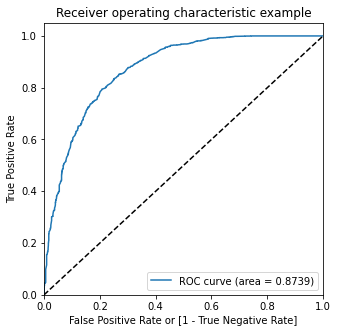

In [64]:
# Linear Regression performance
p1 = performance(rfe_reg, X_train, X_test, y_train, y_test, True)
draw_roc(rfe_reg, X_train, y_train)

## Manual Feature Elemination

In [65]:
# perform p-value and VIF analysis to get best result with a given 
# significance level of 0.03 and VIF cutoff = 1.5
filename = f'{root}'%'stat_multi_model_list.sav'
p_val = 0.001
vif = 1.5
multi_models = manual_feature_elemination(X_train[var_list], 
                                          y_train, model_no=2, 
                                          p_value_cutoff=p_val, 
                                          vif_cutoff=vif, 
                                          save_models=True)
model, best_cols, model_no, _ , auc, reg = multi_models[-1]

Started:  2022-07-23 17:03:45.440214


Started:  2022-07-23 17:03:45.442977
Model:2
Features(13):
AUC:  0.8739


Features    VIF  P>|z|     coef
0                      const  29.43  0.000   4.5277
1   double_slash_redirecting   3.98  0.024  -0.5849
2         Shortining_Service   3.56  0.000   1.5736
3                HTTPS_token   2.56  0.000   0.7470
4                  DNSRecord   1.68  0.000  -0.7827
5                  having_IP   1.43  0.000  -1.1794
6                   Redirect   1.35  0.000   0.7116
7     Links_pointing_to_page   1.25  0.000  -0.6899
8               Google_Index   1.15  0.000  -0.7720
9                Request_URL   1.06  0.000  -0.8548
10         having_Sub_Domain   1.06  0.000  -0.8597
11             Prefix_Suffix   1.06  0.998 -26.6650
12               web_traffic   1.04  0.000  -0.9641
13                       SFH   1.03  0.000  -0.9199

D R O P     S U G G E S T I O N

High p-value for 'Prefix_Suffix'=0.998. Drop Insignificant Variable-'Prefix_Suffix'.
Checkpoint -- Model No:2, Feature count:13
Model:2 took 0.5356888771057129 sec
Ended:  2022-07-23 17:03:45.978054


Started:  2022-07-23 17:03:45.978162
Model:3
Features(12):
AUC:  0.8304


Features    VIF  P>|z|    coef
0                      const  29.42  0.000  4.1919
1   double_slash_redirecting   3.96  0.643 -0.1045
2         Shortining_Service   3.56  0.000  1.4804
3                HTTPS_token   2.56  0.000  0.5990
4                  DNSRecord   1.67  0.000 -0.8117
5                  having_IP   1.42  0.000 -1.1989
6                   Redirect   1.34  0.000  0.9233
7     Links_pointing_to_page   1.23  0.000 -0.7640
8               Google_Index   1.14  0.000 -0.9310
9                Request_URL   1.05  0.000 -0.8936
10         having_Sub_Domain   1.05  0.000 -0.8687
11               web_traffic   1.03  0.000 -0.9142
12                       SFH   1.03  0.000 -0.8099

D R O P     S U G G E S T I O N

High p-value for 'double_slash_redirecting'=0.643. Drop Insignificant Variable-'double_slash_redirecting'.
Checkpoint -- Model No:3, Feature count:12
Model:3 took 0.22500038146972656 sec
Ended:  2022-07-23 17:03:46.203175


Started:  2022-07-23 17:03:46.203277
Model:4
Features(11):
AUC:  0.8303


Features    VIF  P>|z|    coef
0                    const  28.83    0.0  4.1778
1       Shortining_Service   2.68    0.0  1.4301
2              HTTPS_token   2.25    0.0  0.5729
3                DNSRecord   1.64    0.0 -0.8188
4                having_IP   1.41    0.0 -1.2025
5                 Redirect   1.25    0.0  0.9396
6   Links_pointing_to_page   1.23    0.0 -0.7650
7             Google_Index   1.10    0.0 -0.9399
8              Request_URL   1.05    0.0 -0.8939
9        having_Sub_Domain   1.05    0.0 -0.8679
10             web_traffic   1.03    0.0 -0.9128
11                     SFH   1.02    0.0 -0.8086

D R O P     S U G G E S T I O N

High VIF for 'Shortining_Service'=2.68. Drop multicollineared Variable-'Shortining_Service'.
Checkpoint -- Model No:4, Feature count:11
Model:4 took 0.190108060836792 sec
Ended:  2022-07-23 17:03:46.393394


Started:  2022-07-23 17:03:46.393498
Model:5
Features(10):
AUC:  0.8237


Features    VIF  P>|z|    coef
0                    const  27.05    0.0  4.5393
1              HTTPS_token   1.52    0.0  1.1947
2                DNSRecord   1.49    0.0 -0.5445
3                having_IP   1.35    0.0 -1.0403
4   Links_pointing_to_page   1.23    0.0 -0.7510
5                 Redirect   1.18    0.0  0.6659
6             Google_Index   1.08    0.0 -0.8124
7        having_Sub_Domain   1.05    0.0 -0.8722
8              Request_URL   1.04    0.0 -0.9236
9              web_traffic   1.03    0.0 -0.9146
10                     SFH   1.02    0.0 -0.8037

D R O P     S U G G E S T I O N

High VIF for 'HTTPS_token'=1.52. Drop multicollineared Variable-'HTTPS_token'.
Checkpoint -- Model No:5, Feature count:10
Model:5 took 0.18215703964233398 sec
Ended:  2022-07-23 17:03:46.576182


Started:  2022-07-23 17:03:46.577748
Model:6
Features(9):
AUC:  0.8148


Features    VIF  P>|z|    coef
0                   const  25.93  0.000  4.8016
1               having_IP   1.23  0.000 -0.7539
2               DNSRecord   1.22  0.237 -0.1090
3  Links_pointing_to_page   1.21  0.000 -0.6457
4                Redirect   1.11  0.005  0.3330
5            Google_Index   1.07  0.000 -0.6716
6             Request_URL   1.04  0.000 -0.8770
7       having_Sub_Domain   1.04  0.000 -0.8833
8             web_traffic   1.03  0.000 -0.9135
9                     SFH   1.02  0.000 -0.7933

D R O P     S U G G E S T I O N

High p-value for 'DNSRecord'=0.237. Drop Insignificant Variable-'DNSRecord'.
Checkpoint -- Model No:6, Feature count:9
Model:6 took 0.15287494659423828 sec
Ended:  2022-07-23 17:03:46.730659


Started:  2022-07-23 17:03:46.732322
Model:7
Features(8):
AUC:  0.8144


Features    VIF  P>|z|    coef
0                   const  20.73  0.000  4.6961
1               having_IP   1.16  0.000 -0.7308
2  Links_pointing_to_page   1.11  0.000 -0.6215
3                Redirect   1.06  0.002  0.3634
4             Request_URL   1.04  0.000 -0.8717
5             web_traffic   1.03  0.000 -0.9137
6       having_Sub_Domain   1.03  0.000 -0.8873
7            Google_Index   1.02  0.000 -0.6979
8                     SFH   1.02  0.000 -0.7944

D R O P     S U G G E S T I O N

High p-value for 'Redirect'=0.002. Drop Insignificant Variable-'Redirect'.
Checkpoint -- Model No:7, Feature count:8
Model:7 took 0.14481377601623535 sec
Ended:  2022-07-23 17:03:46.877111


Started:  2022-07-23 17:03:46.878709
Model:8
Features(7):
AUC:  0.8121


Features    VIF  P>|z|    coef
0                   const  20.62    0.0  4.7185
1               having_IP   1.11    0.0 -0.7760
2  Links_pointing_to_page   1.11    0.0 -0.6095
3             Request_URL   1.04    0.0 -0.8704
4             web_traffic   1.03    0.0 -0.9100
5       having_Sub_Domain   1.03    0.0 -0.8838
6                     SFH   1.02    0.0 -0.7867
7            Google_Index   1.01    0.0 -0.6741

Checkpoint -- Model No:8, Feature count:7
No more improvements. Stopping here.
Model:8 took 0.14358234405517578 sec
Ended:  2022-07-23 17:03:47.022343
Process took 1.5860216617584229 sec
Ended:  2022-07-23 17:03:47.026270


Training: 


0            1  accuracy    macro avg  weighted avg
precision     0.723322     0.725714  0.724526     0.724518      0.724525
recall        0.722276     0.726753  0.724526     0.724514      0.724526
f1-score      0.722799     0.726233  0.724526     0.724516      0.724525
support    2074.000000  2097.000000  0.724526  4171.000000   4171.000000

Testing: 


0           1  accuracy    macro avg  weighted avg
precision    0.723320    0.748603  0.736337     0.735962      0.736459
recall       0.730539    0.741697  0.736337     0.736118      0.736337
f1-score     0.726912    0.745134  0.736337     0.736023      0.736381
support    501.000000  542.000000  0.736337  1043.000000   1043.000000

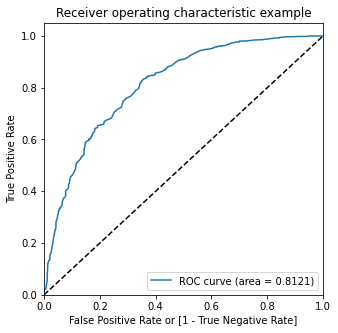

In [66]:
# Logistic Regression RFECV with stastically optimized model performance
# look at the performance
p2 = performance(reg, X_train[best_cols], X_test[best_cols], y_train, y_test, True)
draw_roc(reg, X_train[best_cols], y_train)

## Selected Features in MFE

In [67]:
# top features
multi_models[-1][0].params

const                     4.718487
having_IP                -0.776021
Google_Index             -0.674075
web_traffic              -0.909961
Links_pointing_to_page   -0.609484
Request_URL              -0.870436
SFH                      -0.786680
having_Sub_Domain        -0.883846
dtype: float64

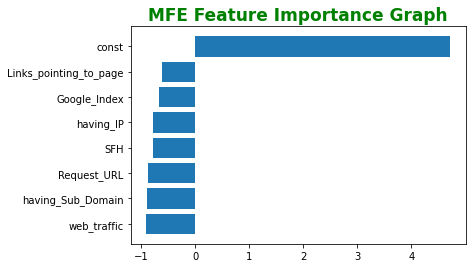

In [68]:
# top performing fetures after manual feature elimination
coefs = multi_models[-1][0].params
coefs = coefs.sort_values()
plt.title("MFE Feature Importance Graph", fontdict=fontdict  )
plt.barh(coefs.index, coefs.values)
plt.show()

In [69]:
feature_cols = ["having_IP", "Google_Index", "web_traffic",
    "Links_pointing_to_page", "Request_URL", "SFH", "having_Sub_Domain"]

## Rebuilding model with best features

In [70]:
# prepare variables
# X = train_unik.drop(columns=["Result"])
y = train_unik.Result
X = X2[feature_cols]
test = test2[feature_cols]

In [71]:
# build model
lrcv_rfe = LogisticRegressionCV(cv=5, 
                            random_state=0, 
                            max_iter=1000,
                            class_weight="balanced",
                            penalty="elasticnet", solver="saga", l1_ratios=[0.01, 0.001],
                            scoring='roc_auc')
# train the model
result_rfe = lrcv_rfe.fit(X, y)

# Model Building(**XGBoost Classifier**)

In [34]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42,
                              scoring="auc")

parameters = {
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, 
                            param_distributions=parameters, 
                            random_state=42, n_iter=200, cv=5, verbose=2, 
                            n_jobs=1, 
                            return_train_score=True)

search.fit(X2, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END learning_rate=0.14236203565420874, max_depth=2, n_estimators=114, subsample=0.892797576724562; total time=   1.3s
[CV] END learning_rate=0.14236203565420874, max_depth=2, n_estimators=114, subsample=0.892797576724562; total time=   1.1s
[CV] END learning_rate=0.14236203565420874, max_depth=2, n_estimators=114, subsample=0.892797576724562; total time=   1.0s
[CV] END learning_rate=0.14236203565420874, max_depth=2, n_estimators=114, subsample=0.892797576724562; total time=   0.9s
[CV] END learning_rate=0.14236203565420874, max_depth=2, n_estimators=114, subsample=0.892797576724562; total time=   1.1s
[CV] END learning_rate=0.20959754525911098, max_depth=4, n_estimators=118, subsample=0.6399899663272012; total time=   1.8s
[CV] END learning_rate=0.20959754525911098, max_depth=4, n_estimators=118, subsample=0.6399899663272012; total time=   1.4s
[CV] END learning_rate=0.20959754525911098, max_depth=4, n_estimators=118

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(random_state=42, scoring='auc'),
                   n_iter=200, n_jobs=1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f753d184ad0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f753d1848d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f753d0ca2d0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f753d0ca1d0>},
                   random_state=42, return_train_score=True, verbose=2)

In [ ]:
# best score
search.best_score_

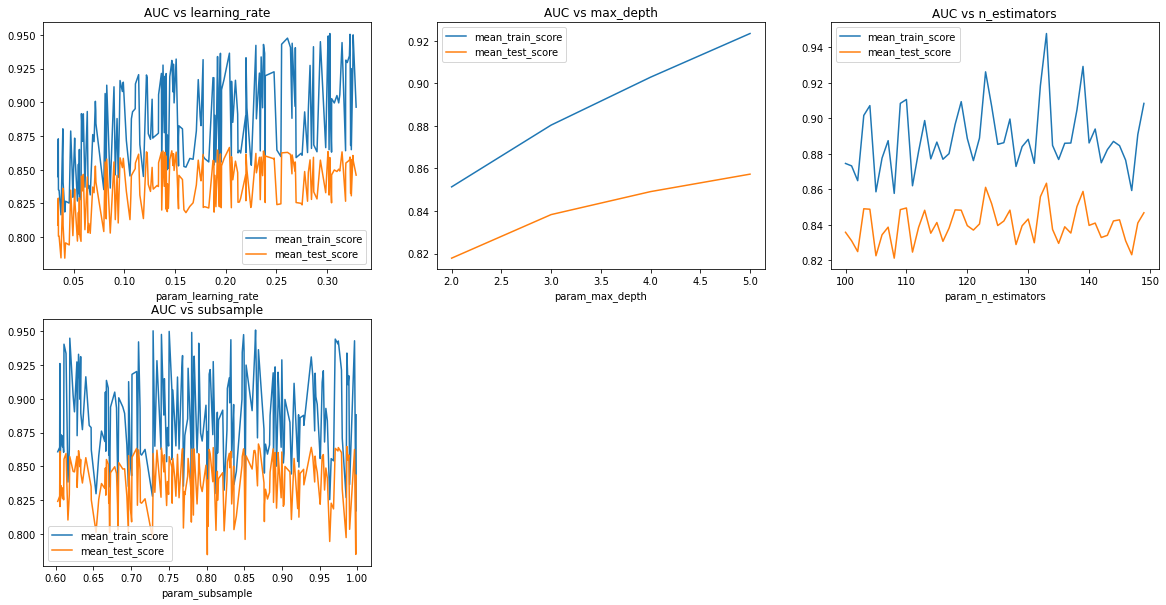

In [36]:
# grid search performance plots
# grid search result
cvdf = pd.DataFrame(search.cv_results_)
# display(cvdf.columns)
features = parameters.keys()
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    # print('param_%s'%f)
    cvdf.groupby('param_%s'%f)['mean_train_score', 'mean_test_score'].mean().plot(ax=ax)
    ax.set_title("AUC vs %s"%f)
plt.show()

## Fine-Tune XGBoost Classifier

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42,
                              scoring="auc")

parameters = {
    "learning_rate": np.linspace(0.18, 0.22, 10), # default 0.1 
    "max_depth": np.arange(5, 10, 1), # default 3
    "n_estimators": np.arange(130, 140, 1), # default 100
    "subsample": np.linspace(0.85 , 0.9, 10)
}

search2 = RandomizedSearchCV(xgb_model, 
                            param_distributions=parameters, 
                            random_state=42, n_iter=500, cv=5, verbose=2, 
                            n_jobs=1, 
                            return_train_score=True)

# fit
search2.fit(X, y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END learning_rate=0.19333333333333333, max_depth=5, n_estimators=130, subsample=0.8555555555555555; total time=   0.6s
[CV] END learning_rate=0.19333333333333333, max_depth=5, n_estimators=130, subsample=0.8555555555555555; total time=   0.6s
[CV] END learning_rate=0.19333333333333333, max_depth=5, n_estimators=130, subsample=0.8555555555555555; total time=   0.6s
[CV] END learning_rate=0.19333333333333333, max_depth=5, n_estimators=130, subsample=0.8555555555555555; total time=   0.7s
[CV] END learning_rate=0.19333333333333333, max_depth=5, n_estimators=130, subsample=0.8555555555555555; total time=   0.7s
[CV] END learning_rate=0.20222222222222222, max_depth=5, n_estimators=138, subsample=0.8833333333333333; total time=   0.7s
[CV] END learning_rate=0.20222222222222222, max_depth=5, n_estimators=138, subsample=0.8833333333333333; total time=   0.7s
[CV] END learning_rate=0.20222222222222222, max_depth=5, n_estimator

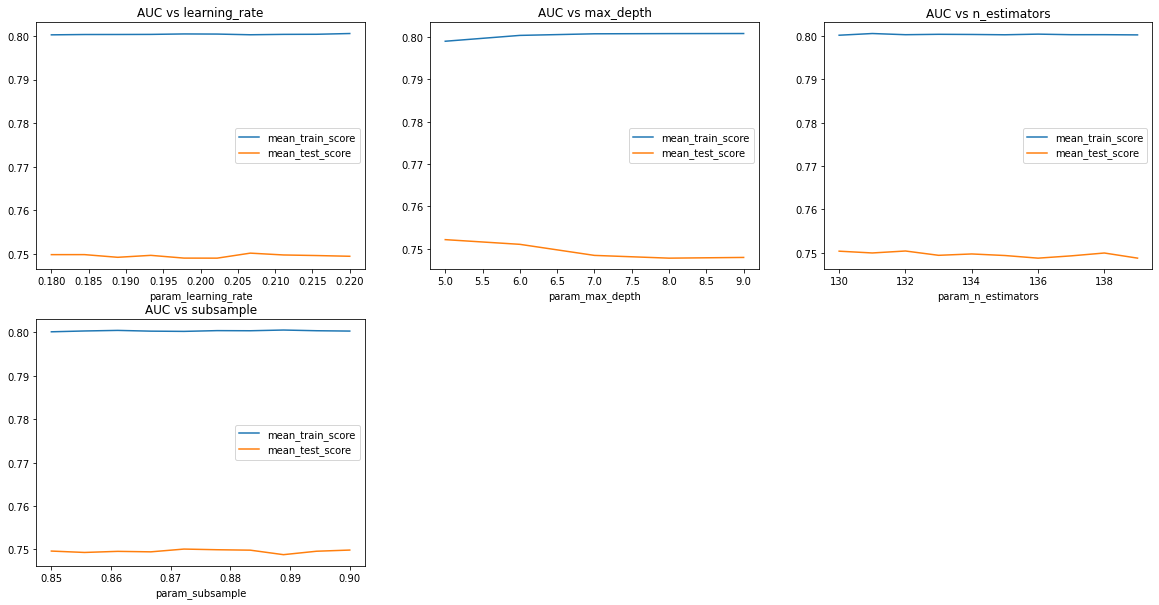

In [40]:
# grid search performance plots
# grid search result
cvdf = pd.DataFrame(search2.cv_results_)
# display(cvdf.columns)
features = parameters.keys()
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    ax=plt.subplot(2,3,i+1)
    # print('param_%s'%f)
    cvdf.groupby('param_%s'%f)['mean_train_score', 'mean_test_score'].mean().plot(ax=ax)
    ax.set_title("AUC vs %s"%f)
plt.show()
# features = parameters.keys()
# plt.figure(figsize=(20, 10))
# for i, f in enumerate(features):
#     ax=plt.subplot(2,3,i+1)
#     cvdf.groupby('param_%s'%f)['mean_train_neg_log_loss', 'mean_test_neg_log_loss'].mean().plot(ax=ax)
#     ax.set_title("Negative Log Loss vs %s"%f)
# plt.show()

In [41]:
# best estimator
search2.best_estimator_

XGBClassifier(learning_rate=0.22, max_depth=5, n_estimators=130,
              random_state=42, scoring='auc', subsample=0.8722222222222222)

In [43]:
# best score
search2.best_score_

0.7562256741313538

In [ ]:
# save the model
dump(search2, root % 'search2_xgb.joblib')

### XGB Final Model

In [44]:
# final XGB Model with fine-tuned parameters
xgb_model3 = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42,
                              scoring="auc",
                              learning_rate= 0.207,
                              max_depth= 5,
                              n_estimators=132,
                              subsample=0.873)

In [45]:
xgb_res3 = xgb_model3.fit(X2, y)
# save the model
dump(xgb_res3, root % 'xgb_res3.joblib')

['/content/drive/MyDrive/TechGig_HPE_ML_2022/HPE_Machine_Learning_Hackathon_CG_2022/Final/xgb_res3.joblib']

### XGB Classifier Feature Support

In [54]:
# XGB Classifier Feature Support
pd.Series(xgb_res3.feature_importances_, X2.columns).sort_values(ascending=False).head(8)

Prefix_Suffix               0.450028
having_Sub_Domain           0.048689
web_traffic                 0.046303
SFH                         0.040338
having_IP                   0.025486
Google_Index                0.022313
popUpWidnow                 0.021925
double_slash_redirecting    0.021812
dtype: float32

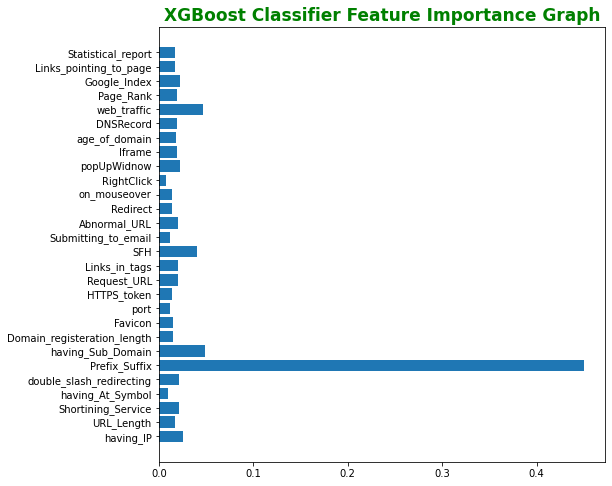

In [46]:
plt.figure(figsize=[8, 8])
plt.title("XGBoost Classifier Feature Importance Graph", fontdict=fontdict  )
plt.barh(X2.columns, xgb_res3.feature_importances_)
plt.show()

## Retrain **XGBoost** with Top-8

In [55]:
top8 = ['Prefix_Suffix',
'having_Sub_Domain',
'web_traffic',
'SFH',
'having_IP',
'Google_Index',
'popUpWidnow',
'double_slash_redirecting']

In [85]:
# build finetuned xgb model
xgb_model4 = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42,
                              scoring="auc",
                              learning_rate= 0.207,
                              max_depth= 5,
                              n_estimators=132,
                              subsample=0.873)

xgb_result4 = xgb_model4.fit(X2[top8], y)

auc = metrics.roc_auc_score(y, model.predict_proba(X2[top8])[:,1])
print(auc)
# print((9997774237814413 - int(10e15*auc)))
# 0.9997774237814413

0.9095396535168883


# Retrain **Random Forest** with Top-8

In [134]:
# prepare grid search object
rf4 = RandomForestClassifier(random_state=0, class_weight='balanced',
                            criterion='entropy',
                            max_features='log2',
                            min_samples_leaf=2,
                            max_depth=19,
                            min_samples_split=2,
                            )
rf4.fit(X, y)
# save the model
dump(rf4, root % 'rf4.joblib')

['/content/drive/MyDrive/TechGig_HPE_ML_2022/HPE_Machine_Learning_Hackathon_CG_2022/Final/rf4.joblib']

# Model Performance Eval.

In [72]:
# prepare final variables
X = X2[top8]
y = train_unik.Result
test = test2[top8]

0.9095396535168883


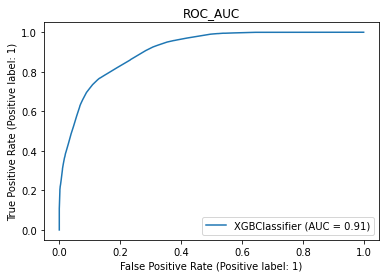

In [136]:
# model = search.best_estimator_
# model = gridcv_dt7.best_estimator_
# model = dt8
# model = gridcv_dt8.best_estimator_
# model = gridcv_rf1.best_estimator_
# model = gridcv_rf2.best_estimator_
# model = dt6
# model = lrcv_rfe
# model = rf4
model = xgb_model4
print(metrics.roc_auc_score(y, model.predict_proba(X)[:,1]))
metrics.plot_roc_curve(model, X, y)
plt.title("ROC_AUC")
plt.show()

In [137]:
# calculate probability values
y_train_proba =pd.Series(model.predict_proba(X)[:, 1])

# prepare a dataframe
y_train_final = pd.DataFrame(columns=['phishing', 'proba'])

y_train_final['phishing'] = np.array(y)
y_train_final['proba'] = y_train_proba
# calculate prediction for different probability values
cutoff_range= np.arange(0, 1.001, 0.001)
for i in cutoff_range:
    y_train_final[f"{round(i,2)}"] = y_train_proba.apply(lambda x: 1 if x >= i else 0)


In [138]:
# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['cutoff', 'accuracy', 'sensi', 'speci','false negative rate', 'false positive rate', 'f1_score'])
for i in cutoff_range:
    cm1 = metrics.confusion_matrix(y_train_final["phishing"], y_train_final[f"{round(i,2)}"] )
    total1=sum(sum(cm1))
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    # metrics
    accuracy = (TN+TP)/total1
    speci = TN/(TN + FP)
    sensi = TP/(TP + FN)
    false_negative_rate = 1-sensi
    false_positive_rate = 1-speci
    precision = TP/(TP + FP)
    recall = sensi
    f1_score = 2 * ((precision * recall)/(precision + recall))
    # update dataframe
    cutoff_df.loc[i] =[i, accuracy, sensi, speci, false_negative_rate, false_positive_rate, f1_score]
cutoff_df.sample(2)

cutoff  accuracy     sensi     speci  false negative rate  \
0.708   0.708  0.800153  0.690792  0.912233             0.309208   
0.533   0.533  0.816839  0.768473  0.866408             0.231527   

       false positive rate  f1_score  
0.708             0.087767  0.777730  
0.533             0.133592  0.809419

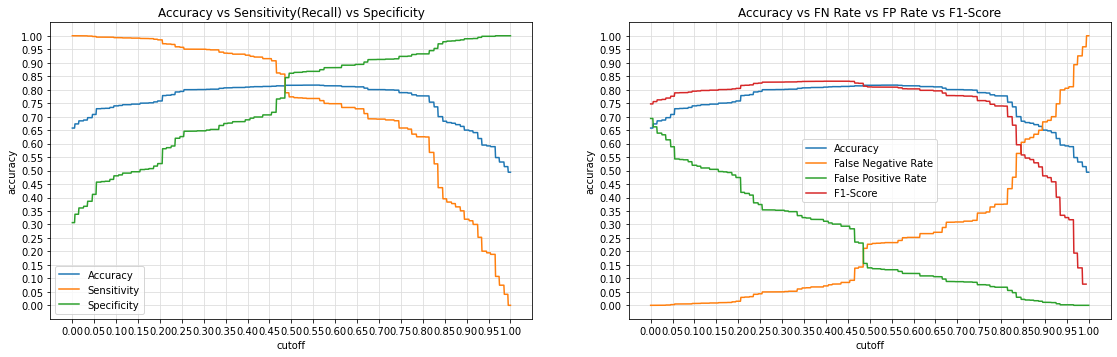

In [139]:
# metric comparison polt
plt.figure(figsize=[19, 12])
ax = plt.subplot(2,2,1)
ax.set_title("Accuracy vs Sensitivity(Recall) vs Specificity")
sns.lineplot(data=cutoff_df, x="cutoff", y="accuracy", label="Accuracy")
sns.lineplot(data=cutoff_df, x="cutoff", y="sensi", label="Sensitivity")
sns.lineplot(data=cutoff_df, x="cutoff", y="speci", label="Specificity")
ax.set_xticks(np.arange(0, 1.05, 0.05))
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.grid(visible=True, color="#dddddd")
ax = plt.subplot(2,2,2)
ax.set_title("Accuracy vs FN Rate vs FP Rate vs F1-Score")
sns.lineplot(data=cutoff_df, x="cutoff", y="accuracy", label="Accuracy")
sns.lineplot(data=cutoff_df, x="cutoff", y="false negative rate", label="False Negative Rate")
sns.lineplot(data=cutoff_df, x="cutoff", y="false positive rate", label="False Positive Rate")
sns.lineplot(data=cutoff_df, x="cutoff", y="f1_score", label="F1-Score")
ax.grid(visible=True, color="#dddddd")
ax.set_xticks(np.arange(0, 1.05, 0.05))
ax.set_yticks(np.arange(0, 1.05, 0.05))
plt.show()

### Optimal `probability cutoff` for prediction

In [140]:
# optimal cutoff finding
closest = np.argmin(np.array(cutoff_df["false positive rate"] - cutoff_df["false negative rate"])**2)
optimal = pd.DataFrame(cutoff_df.iloc[closest]).T
optimal

cutoff  accuracy     sensi    speci  false negative rate  \
0.486   0.486  0.816264  0.788556  0.84466             0.211444   

       false positive rate  f1_score  
0.486              0.15534  0.812891

In [132]:
# optimal values
optimal = round(optimal, 3)
print("Optimal Probability cutoff: ", optimal['cutoff'].values)
print("Accuracy at optimal cutoff: ", optimal['accuracy'].values)
print("Sensitivity at optimal cutoff: ", optimal['sensi'].values)
print("Specificity at optimal cutoff: ", optimal['speci'].values)
print("FNR at optimal cutoff: ", optimal['false negative rate'].values)
print("FPR at optimal cutoff: ", optimal['false positive rate'].values)
print("F1-Score at optimal cutoff: ", optimal['f1_score'].values)

Optimal Probability cutoff:  [0.475]
Accuracy at optimal cutoff:  [0.816]
Sensitivity at optimal cutoff:  [0.794]
Specificity at optimal cutoff:  [0.838]
FNR at optimal cutoff:  [0.206]
FPR at optimal cutoff:  [0.162]
F1-Score at optimal cutoff:  [0.814]


In [133]:
np.random.seed(0)
cutoffs = np.linspace(0.3,0.6, 30)
model_name = 'xgboost4'
display(HTML('<b>Compare with my last result</b>'))

for cutoff_ in cutoffs:
    y_pred = pd.Series(model.predict_proba(test)[:, 1])
    submit = pd.DataFrame(dict(key=test_key, 
                    Result=y_pred.apply(lambda pred: -1 if pred >= cutoff_ else 1))
    )
    # save the result
    submit.to_csv("submission_%s_%f.csv"%(model_name, cutoff_), index=None)
    best = pd.read_csv("LEEvptD.csv")
    # their = pd.read_csv("sample_submission.csv")
    percent_match = (100*best["Result"].eq(submit["Result"]).sum()/len(best))

    print("cutoff=%6.4f(%s) => %5.3f%% match "%(cutoff_, model_name, percent_match))



cutoff=0.3000(xgboost4) => 79.619% match 
cutoff=0.3103(xgboost4) => 79.762% match 
cutoff=0.3207(xgboost4) => 80.000% match 
cutoff=0.3310(xgboost4) => 80.000% match 
cutoff=0.3414(xgboost4) => 79.952% match 
cutoff=0.3517(xgboost4) => 79.952% match 
cutoff=0.3621(xgboost4) => 80.190% match 
cutoff=0.3724(xgboost4) => 80.429% match 
cutoff=0.3828(xgboost4) => 80.238% match 
cutoff=0.3931(xgboost4) => 80.667% match 
cutoff=0.4034(xgboost4) => 80.714% match 
cutoff=0.4138(xgboost4) => 80.571% match 
cutoff=0.4241(xgboost4) => 80.571% match 
cutoff=0.4345(xgboost4) => 80.619% match 
cutoff=0.4448(xgboost4) => 80.571% match 
cutoff=0.4552(xgboost4) => 80.571% match 
cutoff=0.4655(xgboost4) => 80.714% match 
cutoff=0.4759(xgboost4) => 83.476% match 
cutoff=0.4862(xgboost4) => 84.190% match 
cutoff=0.4966(xgboost4) => 83.619% match 
cutoff=0.5069(xgboost4) => 83.619% match 
cutoff=0.5172(xgboost4) => 83.619% match 
cutoff=0.5276(xgboost4) => 83.619% match 
cutoff=0.5379(xgboost4) => 83.524%

# Performance Summary

- In this final phase as there is not scope to see our submission score at the dashboard, we took our last submission file as our, baseline, performance indicator.

- We are essentially trying to match how much percentage of test result is matched with our previous result.

- `cutoff=0.4966(xgboost4) => 84.190% match, AUC:0.9095, Accuracy: ~80% `
- `cutoff=0.4862(rf4) => 84.190% match, AUC:0.9088, Accuracy: ~81%`


# Final model

- Random Forest is giving us a slightly better AUC. We are choosing this model as our final model.
- Our final model is saved at `rf4.joblib` file
- Our feature encoder object is saved at `enc.joblib` file

# <center>THE END</center>